In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
%matplotlib inline
from CifFile import ReadCif
import subprocess

In [2]:
def print_cif(filename):
    """prints information contained within cif file"""
    cif_data = ReadCif(filename)
    print(cif_data)

In [3]:
def convert_cif_to_xyz(cif_filename,xyz_filename=None,obabel="obabel"):
    """converts cif file to xyz file using babel as a subprocess"""
    if xyz_filename is None:
        xyz_filename = path.splitext(cif_filename)[0] + ".xyz"
        
    babel_process = subprocess.run([obabel, "-icif", cif_filename, "-oxyz", "-O{}".format(xyz_filename)], stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    try:
        print(babel_process.stdout.decode("utf-8"))
    except:
        pass
    try:
        print(babel_process.stderr.decode("utf-8"))
    except:
        pass
    if ("molecule converted" in babel_process.stdout.decode("utf-8")) or ("molecule converted" in babel_process.stderr.decode("utf-8")):
        print("XYZ file saved to {}".format(xyz_filename))
    else:
        raise OSError("{} not converted.".format(cif_filename))

### Loading crystal data and finding the center of the pore

In [4]:
mcm41_cif_file = '../data/mcm-41.cif'

We print the contents of the cif file to check the structure and find useful information.

In [5]:
print_cif(mcm41_cif_file)

Writing CSD_CIF_MOLDRAW, <CifFile.StarFile.StarBlock object at 0x7fa89ecc82e8>
All blocks output.

##########################################################################
#               Crystallographic Information Format file
#               Produced by PyCifRW module
#
#  This is a CIF file.  CIF has been adopted by the International
#  Union of Crystallography as the standard for data archiving and
#  transmission.
#
#  For information on this file format, follow the CIF links at
#  http://www.iucr.org
##########################################################################

data_CSD_CIF_MOLDRAW

_audit_creation_date                    08-23-2013
_audit_creation_method                  MOLDRAW
_chemical_formula_sum                   'H102 O335 Si142'
_chemical_formula_moiety                
;
H102 O335 Si142
;
loop_
  _publ_author_name
         Piero     
         Ugliengo  
         Dip.      
         Chimica   
         University          
         of        
         Tori

The cif format is cumbersome for our uses so we convert to [xyz format](https://en.wikipedia.org/wiki/XYZ_file_format) using [Open Babel](https://open-babel.readthedocs.io/en/latest/index.html).

In [6]:
convert_cif_to_xyz(mcm41_cif_file)


1 molecule converted

XYZ file saved to data/MCM-41/mcm-41.xyz


We also generated an xyz file using [VESTA](http://jp-minerals.org/vesta/en/) and load it here.

In [6]:
mcm41_xyz_file = "../data/mcm-41.xyz"
#mcm41_xyz_file = "../data/mcm-41-VESTA.xyz"
mcm41_basename = path.basename(path.splitext(mcm41_xyz_file)[0]) #We'll use this when naming files later

Useful parameters can be extracted from the cif file and atom positions from the xyz file.

In [7]:
mcm41_cif = ReadCif(mcm41_cif_file)
mcm41_xyz = np.genfromtxt(mcm41_xyz_file,skip_header=2,dtype=[('type_symbol','|S2'),('x','f'),('y','f'),('z','f')])

In [8]:
label =       np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_label'])
type_symbol = np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_type_symbol'])
fract_x =     np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_fract_x'],dtype=float)
fract_y =     np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_fract_y'],dtype=float)
fract_z =     np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_fract_z'],dtype=float)
cell_length_a = float(mcm41_cif['csd_cif_moldraw']['_cell_length_a'])
cell_length_b = float(mcm41_cif['csd_cif_moldraw']['_cell_length_b'])
cell_length_c = float(mcm41_cif['csd_cif_moldraw']['_cell_length_c'])
cell_angle_alpha = float(mcm41_cif['csd_cif_moldraw']['_cell_angle_alpha'])*np.pi/180.0
cell_angle_beta = float(mcm41_cif['csd_cif_moldraw']['_cell_angle_beta'])*np.pi/180.0
cell_angle_gamma = float(mcm41_cif['csd_cif_moldraw']['_cell_angle_gamma'])*np.pi/180.0

# Average radius as described by creator of cif file in https://doi.org/10.1016/j.apsusc.2015.01.084
mcm41_cif_pore_radius = 15.51

Lattice vectors can be generated from the extracted parameters.

In [9]:
ax1 = cell_length_a
ay1 = 0.0
ax2 = cell_length_b*np.cos(cell_angle_gamma)
ay2 = cell_length_b*np.sin(cell_angle_gamma)
az = cell_length_c

Let's make a quick plot of a bird's-eye view of a few repititions of the unit cell in order to have a sense of the crystal structure.

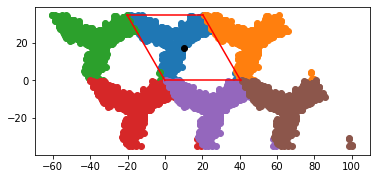

In [10]:
fig,ax = plt.subplots()
ax.scatter(mcm41_xyz['x'],mcm41_xyz['y'])
plt.plot([0,cell_length_a],[0,0],color='r')
plt.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.scatter(mcm41_xyz['x']+ax1,mcm41_xyz['y'])
ax.scatter(mcm41_xyz['x']-ax1,mcm41_xyz['y'])
ax.scatter(mcm41_xyz['x']-ax1-ax2,mcm41_xyz['y']-ay2)
ax.scatter(mcm41_xyz['x']-ax2,mcm41_xyz['y']-ay2)
ax.scatter(mcm41_xyz['x']+ax1-ax2,mcm41_xyz['y']-ay2)
ax.scatter([(ax2+ax1)/2],[(ay2+ay1)/2],color='k')
ax.set_aspect(1)

We can easily see the cif file was not centered on pore. Let's shift the xyz file data in order to have a pore centered unit cell. First we determine the pore center within the unit cell by finding the point that maximizes the sum of the distance between it and all atoms in the unit cell using periodic boundary conditions in the xy-plane.

In [11]:
def putInBC(r,side,pSide = None):
    pSide = side if not pSide else pSide
    ind = (r >= (0.5 * side)) + r < -(0.5 * side)
    s = r
    s[ind] = (r[ind] + 2*side[ind]) % side[ind]
    s[s>=.5*side] -= side[s>=.5*side]
    return s

In [12]:
def total_distance_inv(r,r_cell,side,pSide = None):
    sep = []
    for s in (r_cell - r):
        sep.append(putInBC(s,side,pSide).tolist())
    return -np.sum(np.linalg.norm(np.array(sep),axis=1))

In [13]:
from scipy.optimize import minimize

In [14]:
# Set up transfer matrices to transfer from unit cell coordinates to Cartesian coordinates
B = np.array([[1,np.cos(cell_angle_gamma)],[0,np.sin(cell_angle_gamma)]]) #transfer to Cartesian
A = np.linalg.inv(B) #transfer to unit cell coords

side = np.array([cell_length_a,cell_length_b]) #side lengths of unit cell
initial_guess_uc = np.array([0.75*side[0],0.25*side[1]]) #pore center is in that empty space somewhere!
initial_guess = np.dot(B,initial_guess_uc) # initial guess in unit Cartesian coordinates

xy = np.array([mcm41_xyz['x'],mcm41_xyz['y']]).T #xy coordinates of all atoms in MCM-41
xy_uc = np.dot(A,xy.T).T-(side/2.0) #xy in unit cell coordinates



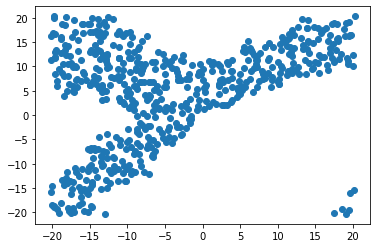

In [15]:
plt.scatter(xy_uc[:,0],xy_uc[:,1])

In [16]:
# Set up transfer matrices to transfer from unit cell coordinates to Cartesian coordinates
B = np.array([[cell_length_a,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)]]) #transfer to Cartesian
A = np.linalg.inv(B) #transfer to unit cell coords

side = np.array([1.0,1.0]) #side lengths of unit cell
initial_guess_uc = np.array([0.75*side[0],0.25*side[1]]) #pore center is in that empty space somewhere!
initial_guess = np.dot(B,initial_guess_uc) # initial guess in unit Cartesian coordinates

xy = np.array([mcm41_xyz['x'],mcm41_xyz['y']]).T #xy coordinates of all atoms in MCM-41
xy_uc = np.dot(A,xy.T).T-(side/2.0) #xy in unit cell coordinates (shifted for PBC function to work)



In [17]:
pore_center_uc = minimize(total_distance_inv,initial_guess_uc,args=(xy_uc,side)) # Pore center unit cell coordinates

In [18]:
pore_center_uc

      fun: -278.602358312552
 hess_inv: array([[0.00072914, 0.00031277],
       [0.00031277, 0.00066149]])
      jac: array([0.49666977, 0.21615219])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 7
     njev: 101
   status: 2
  success: False
        x: array([2.18591382, 0.74164276])

In [19]:
pore_center = np.dot(B,putInBC(pore_center_uc.x,side)+side/2) # Pore center in Cartesian coordinates (shift back before inversion)

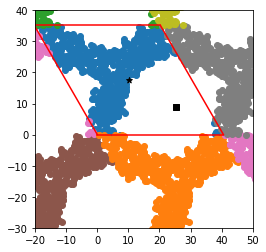

In [20]:
fig,ax = plt.subplots()
ax.scatter(mcm41_xyz['x'],mcm41_xyz['y'])
ax.plot([0,cell_length_a],[0,0],color='r')
ax.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
for i in range(-3,3):
    for j in range(-3,3):
        if (i!=0) or (j!=0):
            ax.scatter(mcm41_xyz['x']+i*ax1+j*ax2,mcm41_xyz['y']+i*ay1+j*ay2)
#ax.scatter([(ax2+ax1)/2],[(ay2+ay1)/2],color='k')
ax.scatter(initial_guess[0],initial_guess[1],color='k',label=r'unit cell center',marker="s")
ax.scatter(pore_center[0],pore_center[1],color='r',label=r'pore center',marker="x")
ax.scatter(np.dot(B,side/2.0)[0],np.dot(B,side/2.0)[1],color='k',label=r'unit cell center',marker="*")
ax.set_xlim(-20,50)
ax.set_ylim(-30,40)
ax.set_aspect(1)

Now that we know the pore center location, we can shift the atom locations to have a pore centered unit cell!

In [21]:
xy_uc_shifted = []
for c in xy_uc-pore_center_uc.x:
    xy_uc_shifted.append(putInBC(c,side))
xy_uc_shifted = np.array(xy_uc_shifted)

In [22]:
xy_shifted = []
for c in xy_uc_shifted:
    xy_shifted.append(np.dot(B,c + side/2.0))
xy_shifted = np.array(xy_shifted)

In [23]:
unit_cell_center = np.dot(B,side/2.0)

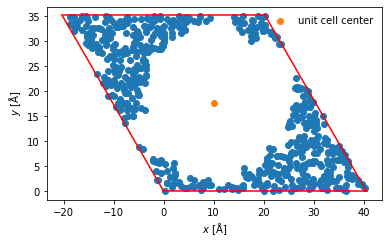

In [24]:
fig,ax = plt.subplots()
ax.scatter(xy_shifted[:,0],xy_shifted[:,1])
ax.plot([0,cell_length_a],[0,0],color='r')
ax.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.scatter(unit_cell_center[0],unit_cell_center[1],label=r'unit cell center')
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
ax.set_aspect(1)
ax.legend(loc=1,frameon=False)
#fig.savefig('plots/MCM-41-shifted.svg',bbox_inches='tight')

Now that we have the unit cell centered on pore, we are ready to try to determine the effective parameters for the helium-MCM-41 interaction. First we need to define some of the interaction potentials we need.

In [25]:
from scipy.special import ellipk, ellipe

def Veffective(rho,sigma,n_epsilon,R):
    pf = np.pi*n_epsilon*(sigma**3)/3.0
    t9 = v9(rho/R)*((sigma/R)**9)
    t3 = v3(rho/R)*((sigma/R)**3)
    return pf*(t9-t3)

def Veffective_AB(rho,A,B,R):
    t9 = A*v9(rho/R)*((1.0/R)**9)
    t3 = B*v3(rho/R)*((1.0/R)**3)
    return t9-t3

def Vshell(rho,sigma,n,R1,R2):
    pf = np.pi*n*(sigma**3)/3.0
    t9 = v9(rho/R1)*((sigma/R1)**9)
    t3 = v3(rho/R1)*((sigma/R1)**3)
    y9 = v9(rho/R2)*((sigma/R2)**9)
    y3 = v3(rho/R2)*((sigma/R2)**3)
    return pf*(y3-y9+t9-t3)

def v9(x):
    pf = 1.0/(240.0*((1.0-(x**2))**9))
    t1 = (1091.0 + (11156.0*(x**2)) + (16434.0*(x**4)) + (4052.0*(x**6)) + (35*(x**8)))*ellipe(x**2)
    t2 = 8.0 * (1.0-(x**2)) * (1.0 + (7.0*(x**2))) * (97.0 + (134.0*(x**2)) + (25.0*(x**4))) * ellipk(x**2)
    return pf*(t1-t2)

def v3(x):
    pf = 2.0/((1.0-(x**2))**3)
    t1 = (7.0 + (x**2)) * ellipe(x**2)
    t2 = 4.0 * (1.0-(x**2)) * ellipk(x**2)
    return pf*(t1-t2)

def U(r,sigma,epsilon):
    """standard 12-6 Lennard-Jones"""
    pf = 4.0 * epsilon
    t12 = (sigma/r)**12
    t6 = (sigma/r)**6
    return pf * (t12 - t6)

def U_mb(r,sigma,epsilon):
    V = 0.0
    for i in range(len(r)):
        V += U(r[i],sigma[i],epsilon[i])
    return V
    

Our prescription for determining `sigma` and `n_epsilon` is as follows. We select some cutoff radius $r_\mathrm{cut}$ and calculate the manybody potential as a sum of 12-6 Lennard-Jones potentials between helium at some test point within the pore at $z=0.0$ and all species within a single layer of the crystal (with repititions in the xy-plane and none in the z direction). Then we perform the same treatment, increasing the cutoff radius until there is no change in the manybody potential to float precision. We then do the same with some cutoff in the z direction, $z_\mathrm{cut}$, with repititions of the crystal layer out to $r_\mathrm{cut}$ in the z direction. This is performed for several points within the pore and then radial cuts are fit to $V(\rho,\sigma,n\epsilon,R)$ and the results are averaged.

Let's begin by shifting the xyz positions of the MCM-41 and setting up the mixed $\sigma$ and $\epsilon$ parameters.

In [26]:
mcm41_xyz_shifted = np.copy(mcm41_xyz)

In [27]:
mcm41_xyz_shifted['x'] = xy_shifted[:,0] - unit_cell_center[0]
mcm41_xyz_shifted['y'] = xy_shifted[:,1] - unit_cell_center[1]
mcm41_xyz_shifted['z'] -= cell_length_c/2.0

In [28]:
# sigma and epsilon parameters for atoms in silica and helium
# See https://doi.org/10.1016/j.apsusc.2015.01.084 and https://doi.org/10.1016/S0927-7757(01)00628-8
sigmaarr = np.array([(3.804,3.033,2.846,2.640,3.405,2.782)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])
epsilonarr = np.array([(155.858,48.115,0.0503,10.9,119.8,37.29134539)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])

# functions to mix the LJ parameters
# See https://doi.org/10.1016/S0927-7757(01)00628-8
def mixsigma(s1,s2):
    return (s1+s2)/2.0

def mixepsilon(e1,e2):
    return (e1*e2)**0.5

In [29]:
# Some convenience arrays for sigma and epsilon while iterating through atom positions
sarr = np.zeros_like(mcm41_xyz_shifted['x'])
earr = np.zeros_like(mcm41_xyz_shifted['x'])
for n in sigmaarr.dtype.names:
    n_byte = str.encode(n)
    sarr[mcm41_xyz_shifted['type_symbol']==n_byte] = mixsigma(sigmaarr[n],sigmaarr['He'])
    earr[mcm41_xyz_shifted['type_symbol']==n_byte] = mixepsilon(epsilonarr[n],epsilonarr['He'])

In [30]:
def U_cut(r = [0.0,0.0,0.0], # test point
                V = 0.0,
                r_cut_old = 0.0,
                r_cut = 900.0,
                i_start = 0,
                z_cut_old = 0.0,
                z_cut = 40.0,
                k_start = 0):

    
    min_i = 999999999
    min_k = 999999999
    max_r = r_cut
    max_z = z_cut
    
    k = k_start
    break_z = True
    while break_z:
        break_z_1 = False
        break_z_2 = False
        break_z_3 = False
        break_z_4 = False
        if k > 0:
            k_arr = [-k,k]
        else:
            k_arr = [0]
            
        for kk in k_arr:
            break_r_1 = False
            break_r_2 = False
            break_r_3 = False
            break_r_4 = False
            if (i_start == 0):
                i=0
                num_r_added = 0
                num_z_added = 0
                x = mcm41_xyz_shifted['x']
                y = mcm41_xyz_shifted['y']
                z = mcm41_xyz_shifted['z'] + kk*cell_length_c
                rsep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2))
                zsep = abs(z - r[2])
                sep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2) + ((z-r[2])**2))
                rsep_lte_rcut = (rsep <= r_cut)
                zsep_lte_zcut = (zsep <= z_cut)
                if not np.all(rsep_lte_rcut):
                    min_i = min(min_i,i)
                if not np.all(zsep_lte_zcut):
                    min_k = min(min_k,k)
                rsep_gt_rcutold = (rsep > r_cut_old)
                zsep_gt_zcutold = (zsep > z_cut_old)
                rsep_ind = rsep_lte_rcut * rsep_gt_rcutold
                zsep_ind = zsep_lte_zcut * zsep_gt_zcutold
                sep_ind = rsep_ind*zsep_ind
                num_r_added += np.sum(rsep_ind)
                num_z_added += np.sum(zsep_ind)
                max_r = max(max_r,rsep.max())
                max_z = max(max_z,zsep.max())
                V += U_mb(sep[sep_ind],sarr[sep_ind],earr[sep_ind])
                if (num_r_added == 0):
                    break_r_1 = True
                    break_r_2 = True
                    break_r_3 = True
                    break_r_4 = True
                if (num_z_added == 0):
                    break_z_1 = True
                    break_z_2 = True
                    break_z_3 = True
                    break_z_4 = True
                i = i_start + 1
            else:
                i = i_start
            while True:
                if not break_r_1:
                    num_r_added = 0
                    num_z_added = 0
                    for j in np.arange(-i,i+1):
                        ii = i
                        jj = j
                        x = mcm41_xyz_shifted['x'] + ii*ax1 + jj*ax2
                        y = mcm41_xyz_shifted['y'] + ii*ay1 + jj*ay2
                        z = mcm41_xyz_shifted['z'] + kk*cell_length_c
                        rsep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2))
                        zsep = abs(z - r[2])
                        sep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2) + ((z-r[2])**2))
                        rsep_lte_rcut = (rsep <= r_cut)
                        zsep_lte_zcut = (zsep <= z_cut)
                        if not np.all(rsep_lte_rcut):
                            min_i = min(min_i,i)
                        if not np.all(zsep_lte_zcut):
                            min_k = min(min_k,k)
                        rsep_gt_rcutold = (rsep > r_cut_old)
                        zsep_gt_zcutold = (zsep > z_cut_old)
                        rsep_ind = rsep_lte_rcut * rsep_gt_rcutold
                        zsep_ind = zsep_lte_zcut * zsep_gt_zcutold
                        sep_ind = rsep_ind*zsep_ind
                        num_r_added += np.sum(rsep_ind)
                        num_z_added += np.sum(zsep_ind)
                        max_r = max(max_r,rsep.max())
                        max_z = max(max_z,zsep.max())
                        V += U_mb(sep[sep_ind],sarr[sep_ind],earr[sep_ind])
                    if (num_r_added == 0):
                        break_r_1 = True
                    if (num_z_added == 0):
                        break_z_1 = True
                if not break_r_2:
                    num_r_added = 0
                    num_z_added = 0
                    for j in np.arange(-i,i+1):
                        ii = -i
                        jj = j
                        x = mcm41_xyz_shifted['x'] + ii*ax1 + jj*ax2
                        y = mcm41_xyz_shifted['y'] + ii*ay1 + jj*ay2
                        z = mcm41_xyz_shifted['z'] + kk*cell_length_c
                        rsep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2))
                        zsep = abs(z - r[2])
                        sep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2) + ((z-r[2])**2))
                        rsep_lte_rcut = (rsep <= r_cut)
                        zsep_lte_zcut = (zsep <= z_cut)
                        if not np.all(rsep_lte_rcut):
                            min_i = min(min_i,i)
                        if not np.all(zsep_lte_zcut):
                            min_k = min(min_k,k)
                        rsep_gt_rcutold = (rsep > r_cut_old)
                        zsep_gt_zcutold = (zsep > z_cut_old)
                        rsep_ind = rsep_lte_rcut * rsep_gt_rcutold
                        zsep_ind = zsep_lte_zcut * zsep_gt_zcutold
                        sep_ind = rsep_ind*zsep_ind
                        num_r_added += np.sum(rsep_ind)
                        num_z_added += np.sum(zsep_ind)
                        max_r = max(max_r,rsep.max())
                        max_z = max(max_z,zsep.max())
                        V += U_mb(sep[sep_ind],sarr[sep_ind],earr[sep_ind])
                    if (num_r_added == 0):
                        break_r_2 = True
                    if (num_z_added == 0):
                        break_z_2 = True
                if not break_r_3:
                    num_r_added = 0
                    num_z_added = 0
                    for j in np.arange(-(i-1),i):
                        ii = j
                        jj = i
                        x = mcm41_xyz_shifted['x'] + ii*ax1 + jj*ax2
                        y = mcm41_xyz_shifted['y'] + ii*ay1 + jj*ay2
                        z = mcm41_xyz_shifted['z'] + kk*cell_length_c
                        rsep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2))
                        zsep = abs(z - r[2])
                        sep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2) + ((z-r[2])**2))
                        rsep_lte_rcut = (rsep <= r_cut)
                        zsep_lte_zcut = (zsep <= z_cut)
                        if not np.all(rsep_lte_rcut):
                            min_i = min(min_i,i)
                        if not np.all(zsep_lte_zcut):
                            min_k = min(min_k,k)
                        rsep_gt_rcutold = (rsep > r_cut_old)
                        zsep_gt_zcutold = (zsep > z_cut_old)
                        rsep_ind = rsep_lte_rcut * rsep_gt_rcutold
                        zsep_ind = zsep_lte_zcut * zsep_gt_zcutold
                        sep_ind = rsep_ind*zsep_ind
                        num_r_added += np.sum(rsep_ind)
                        num_z_added += np.sum(zsep_ind)
                        max_r = max(max_r,rsep.max())
                        max_z = max(max_z,zsep.max())
                        V += U_mb(sep[sep_ind],sarr[sep_ind],earr[sep_ind])
                    if (num_r_added == 0):
                        break_r_3 = True
                    if (num_z_added == 0):
                        break_z_3 = True
                if not break_r_4:
                    num_r_added = 0
                    num_z_added = 0
                    for j in np.arange(-(i-1),i):
                        ii = j
                        jj = -i
                        x = mcm41_xyz_shifted['x'] + ii*ax1 + jj*ax2
                        y = mcm41_xyz_shifted['y'] + ii*ay1 + jj*ay2
                        z = mcm41_xyz_shifted['z'] + kk*cell_length_c
                        rsep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2))
                        zsep = abs(z - r[2])
                        sep = np.sqrt(((x-r[0])**2) + ((y-r[1])**2) + ((z-r[2])**2))
                        rsep_lte_rcut = (rsep <= r_cut)
                        zsep_lte_zcut = (zsep <= z_cut)
                        if not np.all(rsep_lte_rcut):
                            min_i = min(min_i,i)
                        if not np.all(zsep_lte_zcut):
                            min_k = min(min_k,k)
                        rsep_gt_rcutold = (rsep > r_cut_old)
                        zsep_gt_zcutold = (zsep > z_cut_old)
                        rsep_ind = rsep_lte_rcut * rsep_gt_rcutold
                        zsep_ind = zsep_lte_zcut * zsep_gt_zcutold
                        sep_ind = rsep_ind*zsep_ind
                        num_r_added += np.sum(rsep_ind)
                        num_z_added += np.sum(zsep_ind)
                        max_r = max(max_r,rsep.max())
                        max_z = max(max_z,zsep.max())
                        V += U_mb(sep[sep_ind],sarr[sep_ind],earr[sep_ind])
                    if (num_r_added == 0):
                        break_r_4 = True
                    if (num_z_added == 0):
                        break_z_4 = True
                if np.all([break_r_1,break_r_2,break_r_3,break_r_4]):
                    break
                i += 1
        k += 1
        if np.all([break_z_1,break_z_2,break_z_3,break_z_4]):
            break_z = False
    return V, min_i, max_r, min_k, max_z

In [41]:
test_point = [0.0,0.0,0.0]
V = 0.0
r_cut_old = 0.0
r_cut = 900.0
i_start = 0
z_cut_old = 0.0
z_cut = np.max(np.abs(mcm41_xyz_shifted['z']))
k_start = 0
V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = i_start,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)
V_old = 0.0
while (np.abs(V - V_old) > np.finfo(np.float32).eps):
    V_old = V
    r_cut_old = r_cut
    r_cut = max_r
    i_start = min_i
    V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = min_i,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)


In [42]:
print("r_cut: {}".format(r_cut))
print("V: {}".format(V))

r_cut: 1933.5260009765625
V: -1.8288710208502033


In [43]:
test_point = [0.0,0.0,0.0]
V = 0.0
r_cut_old = 0.0
r_cut = r_cut
i_start = 0
z_cut_old = 0.0
z_cut = np.max(np.abs(mcm41_xyz_shifted['z']))
k_start = 0
V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = i_start,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)
V_old = 0.0
while (np.abs(V - V_old) > np.finfo(np.float32).eps):
    V_old = V
    z_cut_old = z_cut
    z_cut = max_z
    k_start = min_k
    V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = min_i,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)


In [44]:
np.abs(V - V_old)

1.1899448892904729e-07

In [45]:
print("r_cut: {}".format(r_cut))
print("z_cut: {}".format(z_cut))

r_cut: 1933.5260009765625
z_cut: 252.13479614257812


Now that we have our radius cutoff and z cutoff for a point at the center of the pore, let's see how being close to the edge affects the cutoff.

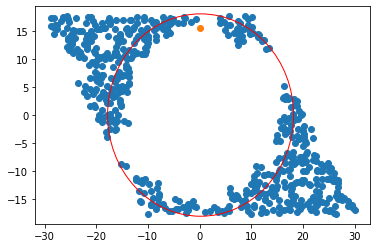

In [90]:
from matplotlib.patches import Circle
circle_radius = mcm41_cif_pore_radius
circle_radius = 18.0
fig,ax = plt.subplots()
ax.scatter(mcm41_xyz_shifted['x'],mcm41_xyz_shifted['y'])
ax.scatter(0.0,mcm41_cif_pore_radius)
circ = Circle((.2,0),circle_radius,facecolor='None',edgecolor='r')
ax.add_patch(circ)

In [ ]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200)
cbar = fig.colorbar(im)
circ = Circle((.2,0),pore_radius,facecolor='None',edgecolor='r')
ax.add_patch(circ)

In [ ]:
plt.scatter(mcm41_xyz_shifted['x'],mcm41_xyz_shifted['y'])
plt.scatter(0.0,mcm41_cif_pore_radius)

In [468]:
test_point = [0.0,mcm41_cif_pore_radius,0.0]
V = 0.0
r_cut_old = 0.0
r_cut = 900.0
i_start = 0
z_cut_old = 0.0
z_cut = np.max(np.abs(mcm41_xyz_shifted['z']))
k_start = 0
V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = i_start,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)
V_old = 0.0
while (np.abs(V - V_old) > np.finfo(np.float32).eps):
    V_old = V
    r_cut_old = r_cut
    r_cut = max_r
    i_start = min_i
    V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = min_i,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)


In [469]:
print("r_cut: {}".format(r_cut))
print("V: {}".format(Vtest))

r_cut: 1941.1162109375
V: -155.11019302572166


In [470]:
test_point = [0.0,0.0,0.0]
V = 0.0
r_cut_old = 0.0
r_cut = r_cut
i_start = 0
z_cut_old = 0.0
z_cut = np.max(np.abs(mcm41_xyz_shifted['z']))
k_start = 0
V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = i_start,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)
V_old = 0.0
while (np.abs(V - V_old) > np.finfo(np.float32).eps):
    V_old = V
    z_cut_old = z_cut
    z_cut = max_z
    k_start = min_k
    V, min_i, max_r, min_k, max_z = U_cut(r = test_point, V = V, r_cut_old = r_cut_old, r_cut = r_cut, i_start = min_i,z_cut_old=z_cut_old,z_cut=z_cut,k_start=k_start)


In [471]:
np.abs(V - V_old)

6.273439256965219e-08

In [472]:
print("r_cut: {}".format(r_cut))
print("z_cut: {}".format(z_cut))

r_cut: 1941.1162109375
z_cut: 18.298561096191406


Being near the edge does not appear to effect the cutoff values! With that we are ready to calculate the potential for many points within the pore.

In [32]:
run_cell = False
#This is an older and slower method for generating the potential within the pore, but useful for low memory machines
#WARNING: the default value for `res` takes a long time to run
if run_cell:
    import datetime
    import time

    r_cut = 2000.0
    z_cut = 20.0

    res = 100j
    meshsize = int(abs(res*res))
    rxmesh,rymesh = np.mgrid[-20:20:res,-20:20:res]
    rzmesh = np.zeros_like(rxmesh)
    rmeshpoints = np.vstack((np.reshape(rxmesh,meshsize),np.reshape(rymesh,meshsize),np.reshape(rzmesh,meshsize))).T

    num_steps = len(rmeshpoints)
    Vmesh = np.zeros(num_steps)
    timearr=[]
    for i in range(num_steps):
        t1 = time.time()
        test_point = rmeshpoints[i]
        Vmesh[i], min_i, max_r, min_k, max_z = U_cut(r = test_point, r_cut = r_cut, z_cut=z_cut)
        t2 = time.time()
        dt = (t2 - t1)
        timearr.append(dt)
        timeleft = str(datetime.timedelta(seconds=np.average(timearr)*(num_steps-i)))
        print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete'.format(i, num_steps, timeleft, 100*i/num_steps), end='\r')
    np.save("../data/{}_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{}_manybody-potential".format(mcm41_basename,extent[0],extent[1],extent[2],extent[3],res),Vmesh)
    np.save("../data/{}_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{}_testpoints".format(mcm41_basename,extent[0],extent[1],extent[2],extent[3],res),rmeshpoints)

The old method for generating the manybody potential took a while to run, so we developed a slightly faster version.

In [56]:
from scipy.spatial.distance import cdist
def U_mb4(V,r,sigma,epsilon,V_ind):
    V += (U(r,sigma,epsilon)*V_ind).sum(-1)
    
def U_cut_step(V,xyz,testpoint,sigma,epsilon,ii,jj,kk,sep,r_cut=2000.0,z_cut=20.0,ax1=1.0,ax2=1.0,ay1=1.0,ay2=1.0,az=1.0,num_added=np.zeros(2,dtype=int)):
    lattice_vector = [ii*ax1 + jj*ax2, ii*ay1 + jj*ay2,kk*az]
    xyz += lattice_vector
    cdist(testpoint[:,0:2], xyz[:,0:2], 'euclidean', out=sep);
    rsep_ind = (sep <= r_cut)
    cdist(testpoint[:,2,np.newaxis], xyz[:,2,np.newaxis], 'euclidean', out=sep);
    zsep_ind = (sep <= z_cut)
    cdist(testpoint, xyz, 'euclidean', out=sep);
    sep_ind = rsep_ind*zsep_ind
    U_mb4(V,sep,sigma,epsilon,sep_ind)
    xyz -= lattice_vector
    num_added[0] += rsep_ind.sum()
    num_added[1] += zsep_ind.sum()
    
def U_cut2(V,xyz,testpoint,sigma,epsilon, # test point
          r_cut = 2000.0,
          z_cut = 20.0,
          ax1=1.0,
          ax2=1.0,
          ay1=1.0,
          ay2=1.0,
          az=1.0,
          i_start = 0,
          k_start = 0):  
    num_added = np.zeros(2,dtype=int)
    sep = np.zeros((len(testpoint),len(xyz)))
    k = k_start
    break_z = True
    while break_z:
        break_z_1 = False
        break_z_2 = False
        break_z_3 = False
        break_z_4 = False
        if k > 0:
            k_arr = [-k,k]
        else:
            k_arr = [0]
            
        for kk in k_arr:
            break_r_1 = False
            break_r_2 = False
            break_r_3 = False
            break_r_4 = False
            if (i_start == 0):
                i=0
                num_added[0] = 0 #r
                num_added[1] = 0 #z
                ii = 0
                jj = 0
                U_cut_step(V,xyz,testpoint,sigma,epsilon,ii,jj,kk,sep,r_cut=r_cut,z_cut=z_cut,ax1=ax1,ax2=ax2,ay1=ay1,ay2=ay2,az=az,num_added=num_added)
                print(num_added)
                if (num_added[0] == 0):
                    break_r_1 = True
                    break_r_2 = True
                    break_r_3 = True
                    break_r_4 = True
                if (num_added[1] == 0):
                    break_z_1 = True
                    break_z_2 = True
                    break_z_3 = True
                    break_z_4 = True
                i = i_start + 1
            else:
                i = i_start
            while True:
                print("k: {} i: {}".format(k,i), end='\r')
                if not break_r_1:
                    num_added[0] = 0 #r
                    num_added[1] = 0 #z
                    for j in np.arange(-i,i+1):
                        ii = i
                        jj = j
                        U_cut_step(V,xyz,testpoint,sigma,epsilon,ii,jj,kk,sep,r_cut=r_cut,z_cut=z_cut,ax1=ax1,ax2=ax2,ay1=ay1,ay2=ay2,az=az,num_added=num_added)
                    if (num_added[0] == 0):
                        break_r_1 = True
                    if (num_added[1] == 0):
                        break_z_1 = True
                if not break_r_2:
                    num_added[0] = 0 #r
                    num_added[1] = 0 #z
                    for j in np.arange(-i,i+1):
                        ii = -i
                        jj = j
                        U_cut_step(V,xyz,testpoint,sigma,epsilon,ii,jj,kk,sep,r_cut=r_cut,z_cut=z_cut,ax1=ax1,ax2=ax2,ay1=ay1,ay2=ay2,az=az,num_added=num_added)
                    if (num_added[0] == 0):
                        break_r_2 = True
                    if (num_added[1] == 0):
                        break_z_2 = True
                if not break_r_3:
                    num_added[0] = 0 #r
                    num_added[1] = 0 #z
                    for j in np.arange(-(i-1),i):
                        ii = j
                        jj = i
                        U_cut_step(V,xyz,testpoint,sigma,epsilon,ii,jj,kk,sep,r_cut=r_cut,z_cut=z_cut,ax1=ax1,ax2=ax2,ay1=ay1,ay2=ay2,az=az,num_added=num_added)
                    if (num_added[0] == 0):
                        break_r_3 = True
                    if (num_added[1] == 0):
                        break_z_3 = True
                if not break_r_4:
                    num_added[0] = 0 #r
                    num_added[1] = 0 #z
                    for j in np.arange(-(i-1),i):
                        ii = j
                        jj = -i
                        U_cut_step(V,xyz,testpoint,sigma,epsilon,ii,jj,kk,sep,r_cut=r_cut,z_cut=z_cut,ax1=ax1,ax2=ax2,ay1=ay1,ay2=ay2,az=az,num_added=num_added)
                    if (num_added[0] == 0):
                        break_r_4 = True
                    if (num_added[1] == 0):
                        break_z_4 = True
                if np.all([break_r_1,break_r_2,break_r_3,break_r_4]):
                    break
                i += 1
        k += 1
        if np.all([break_z_1,break_z_2,break_z_3,break_z_4]):
            break_z = False

In [69]:
xyz = np.zeros((len(mcm41_xyz_shifted),3))
xyz[:,0] = mcm41_xyz_shifted['x']
xyz[:,1] = mcm41_xyz_shifted['y']
xyz[:,2] = mcm41_xyz_shifted['z']

In [33]:
run_cell = False
# we load data from the largest grid we generated by default,  but feel free to experiment and generate your own!
#WARNING: the default value for `res` takes a long time to run
if run_cell:
    r_cut = 2000.0
    z_cut = 20.0

    res = 100j
    res_mesh = int(abs(res))
    meshsize = int(abs(res*res))
    rxmesh,rymesh = np.mgrid[-20:20:res,-20:20:res]
    rzmesh = np.zeros_like(rxmesh)
    rmeshpoints = np.vstack((np.reshape(rxmesh,meshsize),np.reshape(rymesh,meshsize),np.reshape(rzmesh,meshsize))).T

    num_steps = len(rmeshpoints)
    Vmesh = np.zeros(num_steps)

    U_cut2(Vmesh,xyz,rmeshpoints,sarr,earr,
              r_cut = r_cut,
              z_cut = z_cut,
              ax1=ax1,
              ax2=ax2,
              ay1=ay1,
              ay2=ay2,
              az=az,
              i_start = 0,
              k_start = 0)
    fn_Vmesh = "../data/{}_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{}_manybody-potential".format(mcm41_basename,extent[0],extent[1],extent[2],extent[3],res)
    fn_rmeshpoints = "../data/{}_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{}_testpoints".format(mcm41_basename,extent[0],extent[1],extent[2],extent[3],res)
    np.save(fn_Vmesh,Vmesh)
    np.save(fn_rmeshpoints,rmeshpoints)
else:
    fn_Vmesh = "../data/mcm-41_-20.000_20.000_-20.000_20.000_100j_manybody-potential"
    fn_rmeshpoints = "../data/mcm-41_-20.000_20.000_-20.000_20.000_100j_testpoints"
    Vmesh=np.load("{}.npy".format(fn_Vmesh))
    rmeshpoints=np.load("{}.npy".format(fn_rmeshpoints))
    res_mesh = 100

In [34]:
from scipy.interpolate import griddata
interpolate_res = 1000j
grid_x, grid_y = np.mgrid[np.min(rmeshpoints[:,0]):np.max(rmeshpoints[:,0]):interpolate_res, np.min(rmeshpoints[:,1]):np.max(rmeshpoints[:,1]):1000j]
grid_z0 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='nearest')
grid_z1 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='linear')
grid_z2 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='cubic')

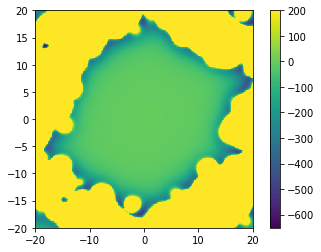

In [35]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200)
cbar = fig.colorbar(im)
fn = "../plots/{}_interpolated_{}".format(path.basename(fn_Vmesh),interpolate_res)
fig.savefig(fn + '.svg')
fig.savefig(fn + '.png',dpi=400)

The effective potential parameters can be determined by fitting to the many body potential. Since we don't want the other pores interfering with the fit, we'll choose some cutoff radius for fitting.

In [37]:
pore_radius=mcm41_cif_pore_radius

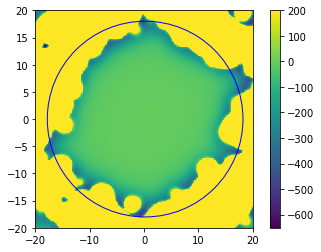

In [117]:
from matplotlib.patches import Circle
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200)
cbar = fig.colorbar(im)
circ = Circle((.2,0),pore_radius,facecolor='None',edgecolor='r')

ax.add_patch(circ)

Radial average of the data

In [42]:
r_int = np.sqrt(grid_x**2 + grid_y**2).flatten()
V_int = grid_z1.flatten()
dr = 0.1
r_cut = pore_radius
num_bins = int(r_cut/dr)
V_average_int = np.zeros(num_bins)
count_array = np.zeros(num_bins,dtype=int)
for i,c_r in enumerate(r_int):
    idx = int(c_r/dr)
    if idx < num_bins:
        
        V_average_int[idx] += V_int[i]
        count_array[idx] += 1
V_average_int /= count_array

(0, 17)

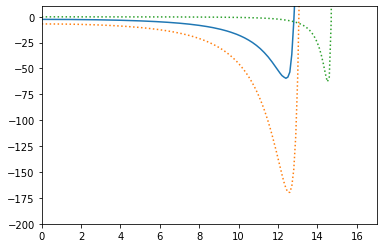

In [65]:
r_bins = np.arange(num_bins)*dr
v_test = Veffective(r_bins,3.44,1.59,15.51)
v_test2 = Veffective(r_bins,1.13,19.0,15.51)
Ar_ne = 36.13613*0.017
Ar_s = 3.0225
Ar_width = 3.76
Ar_potential = Vshell(r_bins,Ar_s,Ar_ne,pore_radius-Ar_width,pore_radius)
fig,ax = plt.subplots()
ax.plot(r_bins,V_average_int)
ax.plot(r_bins,v_test,linestyle=":")
ax.plot(r_bins,v_test2,linestyle=":")
ax.set_ylim(-200,10)
ax.set_xlim(0,17)

(0, 12)

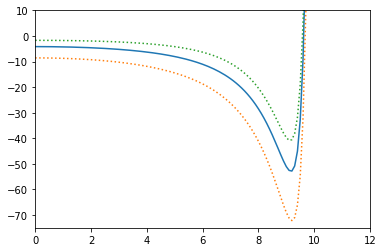

In [67]:
r_bins = np.arange(num_bins)*dr
v_test = Veffective(r_bins,3.44,1.59,15.51)
v_test2 = Veffective(r_bins,1.13,19.0,15.51)
Ar_ne = 36.13613*0.017
Ar_s = 3.0225
Ar_width = 3.76
Ar_potential = Vshell(r_bins,Ar_s,Ar_ne,pore_radius-Ar_width,pore_radius)
fig,ax = plt.subplots()
ax.plot(r_bins,V_average_int+Ar_potential)
ax.plot(r_bins,v_test+Ar_potential,linestyle=":")
ax.plot(r_bins,v_test2+Ar_potential,linestyle=":")
ax.set_ylim(-75,10)
ax.set_xlim(0,12)

In [68]:
def U_min(r,sigma,n,R):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return Veffective(r,sigma,n,R)

In [130]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh
#r_cut_fit = pore_radius
#r_cut_fit = 15.51
r_cut_fit = np.max(xdata)
r_cut_fit = 12.417260089397423
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.06309165 0.06376774 0.10950985]
[ 3.49307214  0.60149803 15.68769307]


In [131]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh
#r_cut_fit = pore_radius
#r_cut_fit = 15.51
r_cut_fit = np.max(xdata)
r_cut_fit = 12.417260089397423
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
r_cut_fit = find_r_cut(rmeshpoints,Vmesh,max_V)
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.06309165 0.06376774 0.10950985]
[ 3.49307214  0.60149803 15.68769307]


In [193]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh
#r_cut_fit = pore_radius
#r_cut_fit = 15.51
r_cut_fit = np.max(xdata)
r_cut_fit = 12.417260089397423
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 100.0
r_cut_fit = find_r_cut(rmeshpoints,Vmesh,max_V)
print(r_cut_fit)

fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

12.574033389572069
[0.06075192 0.03771986 0.09728128]
[ 3.53170583  0.5606419  15.67478861]


(0, 17)

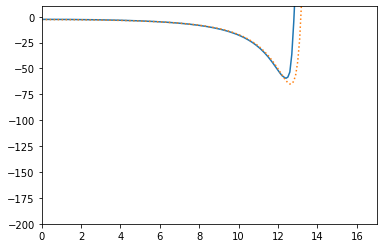

In [194]:
r_bins = np.arange(num_bins)*dr
v_test = Veffective(r_bins,*popt)
fig,ax = plt.subplots()
ax.plot(r_bins,V_average_int)
ax.plot(r_bins,v_test,linestyle=":")
ax.set_ylim(-200,10)
ax.set_xlim(0,17)

(0, 17)

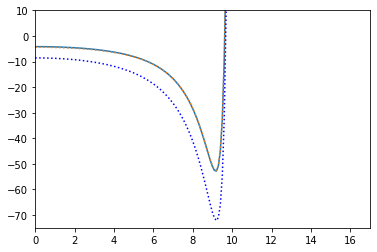

In [199]:
r_bins = np.arange(num_bins)*dr
v_test = Veffective(r_bins,*popt)
v_test2 = Veffective(r_bins,3.44,1.59,15.51)
fig,ax = plt.subplots()
ax.plot(r_bins,V_average_int + Ar_potential)
ax.plot(r_bins,v_test + Ar_potential,linestyle=":")
ax.plot(r_bins,v_test2 + Ar_potential,linestyle=":",color='b')
ax.set_ylim(-75,10)
ax.set_xlim(0,17)

In [100]:
x_cut = 11.5
y_cut = 11.5
V_cut_ind = (np.abs(rmeshpoints[:,0]) > x_cut) * (np.abs(rmeshpoints[:,1]) > y_cut)
Vmesh_cut = np.copy(Vmesh)
Vmesh_cut[V_cut_ind] = 9999

In [183]:
def find_r_cut(rmeshpoints,Vmesh,max_V):
    xdata = np.linalg.norm(rmeshpoints,axis=-1)
    ydata = Vmesh
    sort_idx = np.argsort(xdata)
    xdata = xdata[sort_idx]
    ydata = ydata[sort_idx]
    y_idx = ydata >= max_V
    x_idx = xdata < 7.5
    if max_V >= 0:
        return xdata[y_idx][0]
    else:
        return xdata[y_idx][np.argmax(np.diff(xdata[y_idx]))]
        #return np.diff(xdata[y_idx])
    

In [178]:
find_r_cut(rmeshpoints,Vmesh,-19.0)

array([0.        , 0.        , 0.        , ..., 0.2723108 , 0.00589009,
       0.28126723])

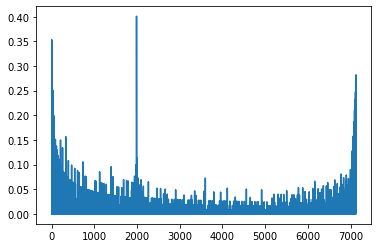

In [182]:
plt.plot(find_r_cut(rmeshpoints,Vmesh,-17.0))
#plt.xlim((1400,1600))

In [124]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh_cut
#r_cut_fit = pore_radius
r_cut_fit = 10.0
#r_cut_fit = np.max(xdata)
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.2238984  0.02007836 0.14932921]
[ 4.93467286  0.06525018 15.24246516]


In [204]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh_cut
#r_cut_fit = pore_radius
r_cut_fit = 10.0
#r_cut_fit = np.max(xdata)
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min_AB, xdata[fitind], ydata[fitind],[300000,5000,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)
popt_sne = AB_to_sigma_nepsilon_err(*popt[:-1],*perr[:-1])
print(popt_sne)

[3.44641904e+06 4.92589545e+01 1.49329225e-01]
[1.42465799e+07 9.86644116e+02 1.52424653e+01]
(4.934672648102247, 0.0652501964472743, 0.2031523657058874, 0.017076582797620025)


In [205]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh_cut
#r_cut_fit = pore_radius
r_cut_fit = 1.0
#r_cut_fit = np.max(xdata)
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
r_cut_fit = find_r_cut(rmeshpoints,Vmesh,max_V)
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min_AB, xdata[fitind], ydata[fitind],[300000,5000,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)
popt_sne = AB_to_sigma_nepsilon_err(*popt[:-1],*perr[:-1])
print(popt_sne)

[2.94931022e+05 7.18424126e+01 1.09509515e-01]
[2.07851169e+06 1.14421373e+03 1.56876888e+01]
(3.4930721206202575, 0.6014966631269453, 0.0903344630914301, 0.11397273820951666)


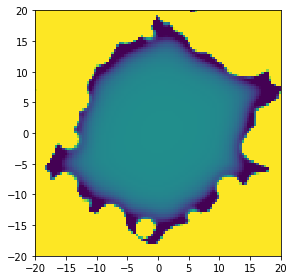

In [101]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(Vmesh_cut.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
fig.tight_layout()

(0, 17)

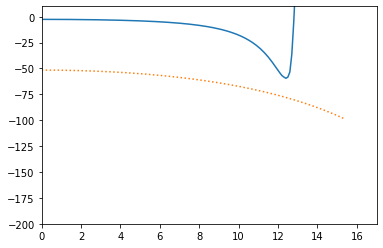

In [92]:
r_bins = np.arange(num_bins)*dr
v_test = Veffective(r_bins,*popt)
fig,ax = plt.subplots()
ax.plot(r_bins,V_average_int)
ax.plot(r_bins,v_test,linestyle=":")
ax.set_ylim(-200,10)
ax.set_xlim(0,17)

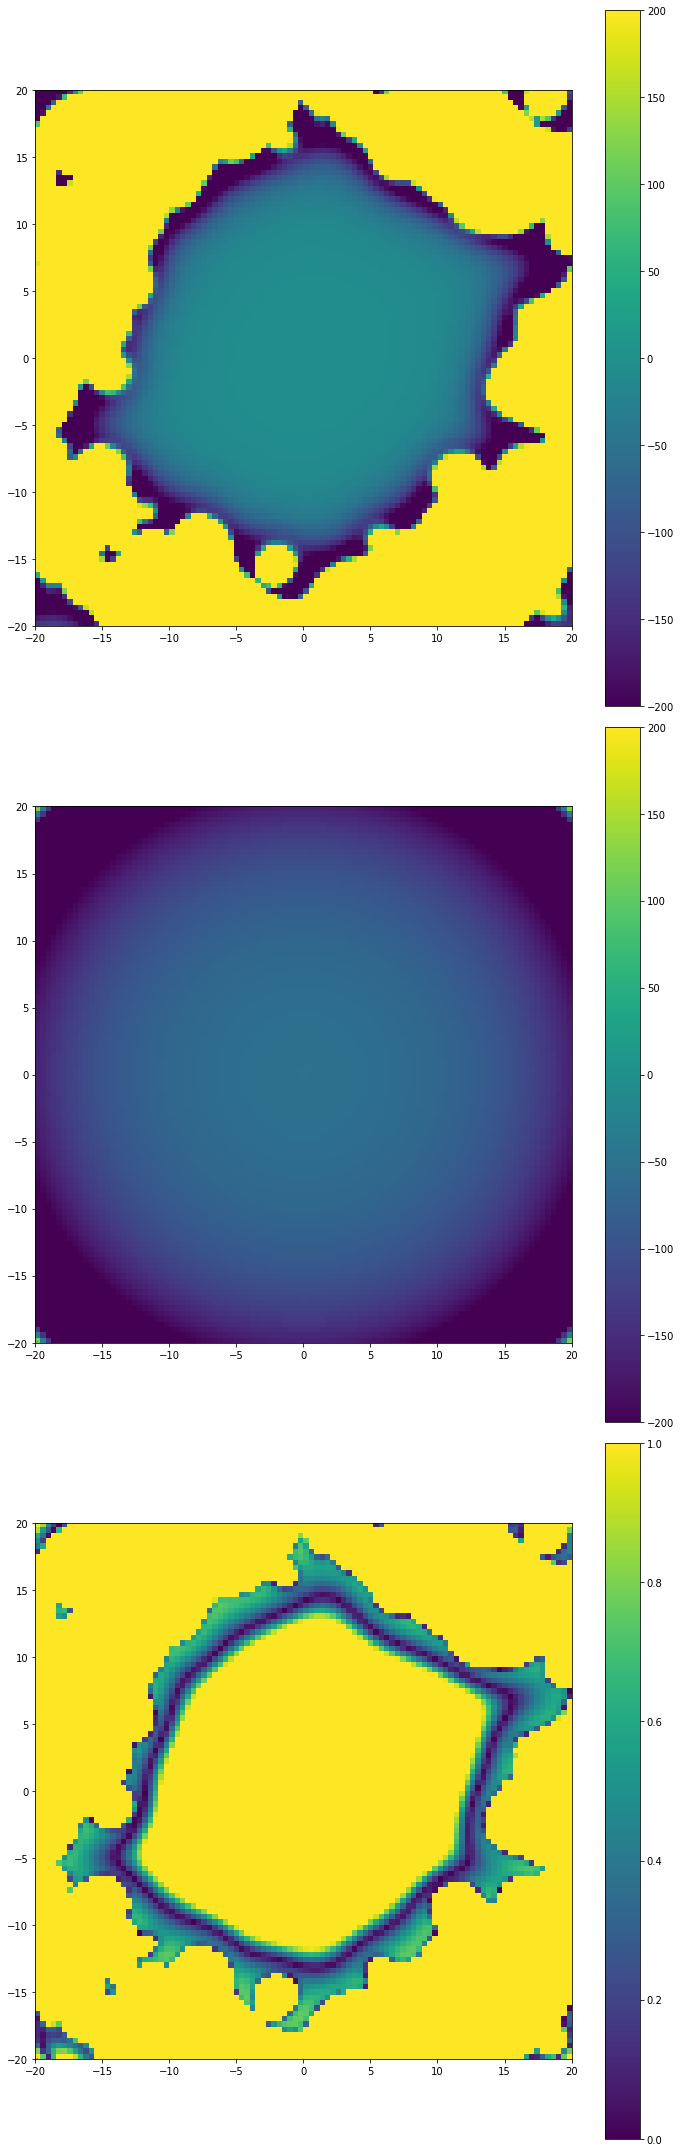

In [93]:
y_predict = U_min(xdata,*popt)
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

We can see from the third plot that there are still regions with large amount of error. Can we do better by restricting the pore radius to the value reported by the author's of the MCM-41 cif?

In [84]:
def U_min2(r,sigma,n):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return Veffective(r,sigma,n,pore_radius)

In [87]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
# We restrict fitting the data to within 10% of the pore wall so the large numbers generated near the wall don't cause numerical instabilites
percent_fit_radius_restricted = 0.95
r_cut_fit = mcm41_cif_pore_radius*percent_fit_radius_restricted

max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min2, xdata[fitind], ydata[fitind],[2.5,5.0],bounds=([0.0,0.0],[np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.00367678 1.53827684]
[ 1.10288395 78.95803163]


(0, 17)

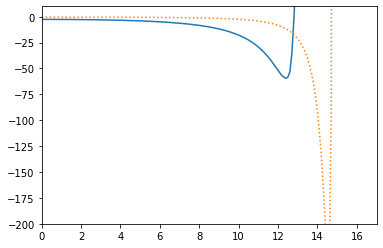

In [88]:
r_bins = np.arange(num_bins)*dr
v_test = U_min2(r_bins,*popt)
fig,ax = plt.subplots()
ax.plot(r_bins,V_average_int)
ax.plot(r_bins,v_test,linestyle=":")
ax.set_ylim(-200,10)
ax.set_xlim(0,17)

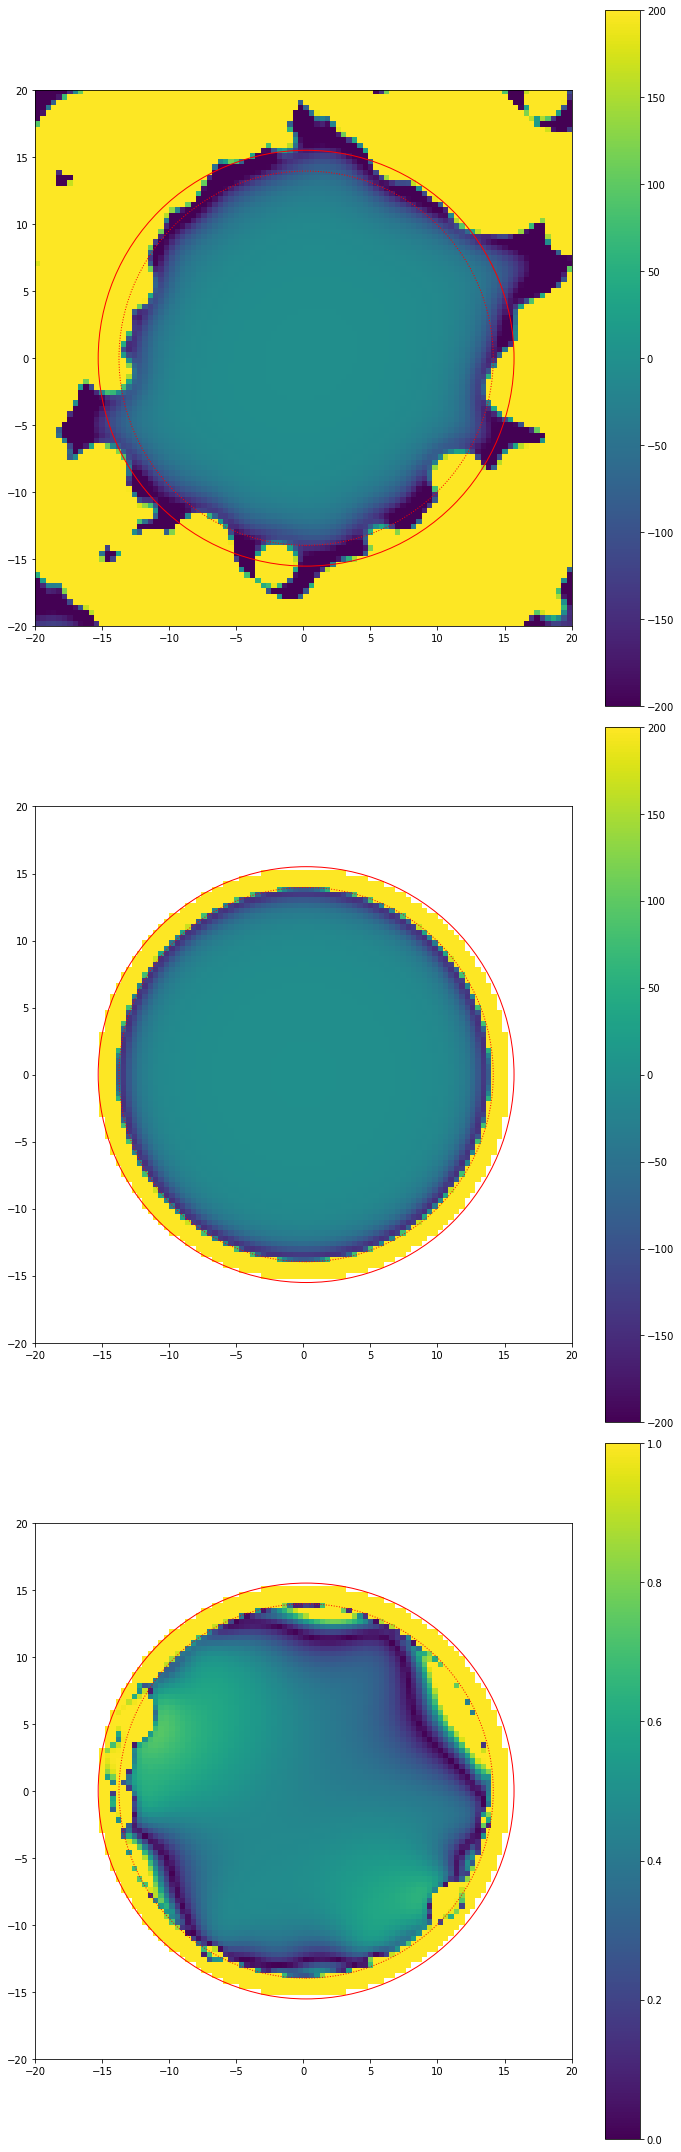

In [302]:
y_predict = U_min2(xdata,*popt)
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)
                
fig.tight_layout()

While the results here are better, they are still not great. Instead we propose a different method. Better results may be achieved if we bin the data radially and average the fit results since we are modeling the nanopore as a cylinderical cavity within a continuous media.

In [303]:
#First we define a few helper functions to go between Cartesian and Polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [304]:
#Here we convert the x and y values in our test point mesh to Polar coordinates and sort based on angle
rhomesh,phimesh=cart2pol(rmeshpoints[:,0],rmeshpoints[:,1])
rhomesh = rhomesh[np.argsort(phimesh)]
Vmesh_pol = Vmesh[np.argsort(phimesh)]
phimesh=np.sort(phimesh)+np.pi

In [305]:
#Next we bin the data in increments of 5 degrees
rhoarr=[]
phiarr=[]
varr=[]
angle = np.arange(0,365,5)*np.pi/180
for i,a in enumerate(angle[0:-1]):
    phiind = (phimesh>=a)*(phimesh<angle[i+1])
    rhotmp = rhomesh[phiind]
    rhoind = np.argsort(rhotmp)
    rhoarr.append(rhomesh[phiind][rhoind])
    phiarr.append(phimesh[phiind][rhoind])
    varr.append(Vmesh_pol[phiind][rhoind])

In [306]:
pore_radius = 15.51

(-300, 10)

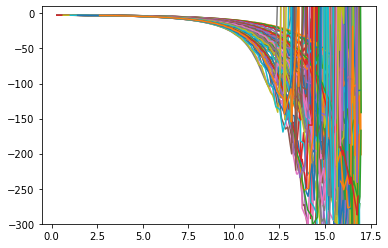

In [307]:
#rcut = pore_radius
rcut = 17.0
for i, c in enumerate(rhoarr):
    cind = c < rcut
    plt.plot(c[cind],varr[i][cind])
plt.ylim(-300,10)

They look Lennard-Jones-ish. Let's perform the fits and see the results. First by allowing the pore radius to vary and then by enforcing 15.51 $\unicode{x212B}$

In [308]:
r_cut_fit = mcm41_cif_pore_radius
max_V = 0.0
fitparams = []
fiterr = []
for i, c in enumerate(rhoarr):
    cind = c < r_cut_fit
    xdata = c[cind]
    ydata = varr[i][cind]

    fitind = (ydata < max_V)
    popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5, 5,rhomesh.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev=200000)

    perr = np.sqrt(np.diag(pcov))
    fitparams.append(popt)
    fiterr.append(perr)
fitparams=np.array(fitparams)
fiterr=np.array(fiterr)

Now we average the fit parameters, throwing out outliers.

In [344]:
def get_average_fit_parameter(fit_parameter,name="fit_parameter",plot_results=True,silent=False):
    mean_fit_parameter = np.mean(fit_parameter)
    std_fit_parameter = np.std(fit_parameter,ddof=1)
    not_min_outlier_ind = fit_parameter >= (mean_fit_parameter - (2*std_fit_parameter))
    not_max_outlier_ind = fit_parameter <= (mean_fit_parameter + (2*std_fit_parameter))
    not_outlier_ind = not_min_outlier_ind*not_max_outlier_ind
    new_mean_fit_parameter = np.mean(fit_parameter[not_outlier_ind])
    if not silent:
        print("{} values in original {} dataset".format(len(fit_parameter),name))
    while True:  
        if not silent:
            print("{} values in truncated {} dataset".format(len(fit_parameter[not_outlier_ind]),name))
        mean_fit_parameter = new_mean_fit_parameter
        std_fit_parameter = np.std(fit_parameter[not_outlier_ind],ddof=1)
        not_min_outlier_ind = fit_parameter >= (mean_fit_parameter - (2*std_fit_parameter))
        not_max_outlier_ind = fit_parameter <= (mean_fit_parameter + (2*std_fit_parameter))
        not_outlier_ind = not_min_outlier_ind*not_max_outlier_ind
        new_mean_fit_parameter = np.mean(fit_parameter[not_outlier_ind])
        if new_mean_fit_parameter == mean_fit_parameter:
            break
    std_fit_parameter = np.std(fit_parameter[not_outlier_ind],ddof=1)/np.sqrt(len(fit_parameter[not_outlier_ind]))
    if plot_results:
        fig,ax = plt.subplots()
        ax.plot(fit_parameter[not_outlier_ind])
        ax.axhline(new_mean_fit_parameter)
        ax.set_title(name)
    return new_mean_fit_parameter, std_fit_parameter

72 values in original $\sigma$ dataset
69 values in truncated $\sigma$ dataset
67 values in truncated $\sigma$ dataset
66 values in truncated $\sigma$ dataset
65 values in truncated $\sigma$ dataset
63 values in truncated $\sigma$ dataset
61 values in truncated $\sigma$ dataset
72 values in original $n\epsilon$ dataset
71 values in truncated $n\epsilon$ dataset
67 values in truncated $n\epsilon$ dataset
64 values in truncated $n\epsilon$ dataset
60 values in truncated $n\epsilon$ dataset
57 values in truncated $n\epsilon$ dataset
54 values in truncated $n\epsilon$ dataset
53 values in truncated $n\epsilon$ dataset
52 values in truncated $n\epsilon$ dataset
72 values in original $R$ dataset
70 values in truncated $R$ dataset
69 values in truncated $R$ dataset
68 values in truncated $R$ dataset
65 values in truncated $R$ dataset
63 values in truncated $R$ dataset
61 values in truncated $R$ dataset
59 values in truncated $R$ dataset


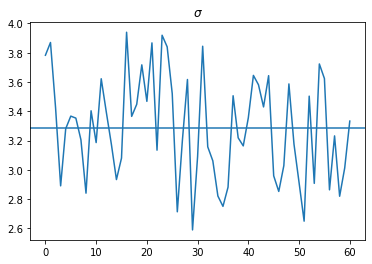

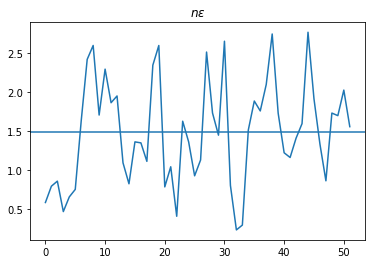

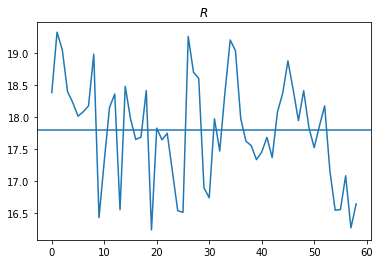

In [310]:
fit_sigma_mean, fit_sigma_err = get_average_fit_parameter(fitparams[:,0],r"$\sigma$")
fit_nepsilon_mean, fit_nepsilon_err = get_average_fit_parameter(fitparams[:,1],r"$n\epsilon$")
fit_radius_mean, fit_radius_err = get_average_fit_parameter(fitparams[:,2],r"$R$")

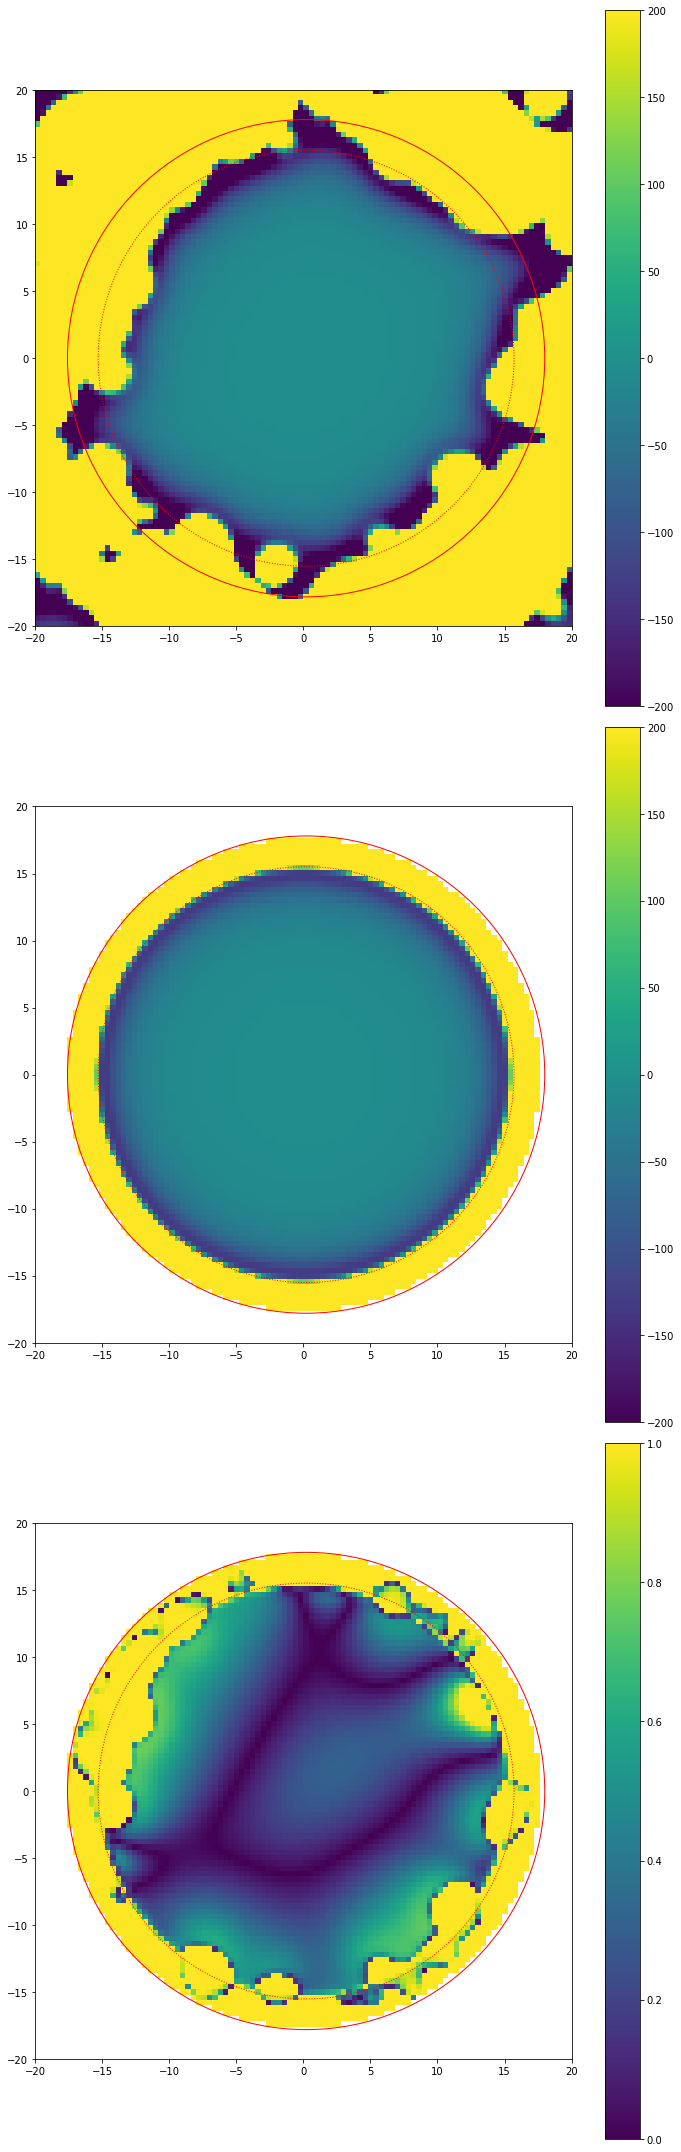

In [311]:
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh
y_predict = U_min(xdata,fit_sigma_mean,fit_nepsilon_mean,fit_radius_mean)
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),fit_radius_mean,facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),fit_radius_mean,facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),fit_radius_mean,facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

A much better fit has been achieved when compared with using the data without binning. How about when we fix the radius?

In [315]:
percent_fit_radius_restricted = 0.95
r_cut_fit = mcm41_cif_pore_radius*percent_fit_radius_restricted
max_V = 0.0
fitparams = []
fiterr = []
for i, c in enumerate(rhoarr):
    cind = c < r_cut_fit
    xdata = c[cind]
    ydata = varr[i][cind]

    fitind = (ydata < max_V)
    popt, pcov = curve_fit(U_min2, xdata[fitind], ydata[fitind],[2.5, 5],bounds=([0.0,0.0],[np.inf,np.inf]),maxfev=200000)

    perr = np.sqrt(np.diag(pcov))
    fitparams.append(popt)
    fiterr.append(perr)
fitparams=np.array(fitparams)
fiterr=np.array(fiterr)

Now we average the fit parameters, throwing out outliers.

72 values in original $\sigma$ dataset
68 values in truncated $\sigma$ dataset
62 values in truncated $\sigma$ dataset
57 values in truncated $\sigma$ dataset
54 values in truncated $\sigma$ dataset
51 values in truncated $\sigma$ dataset
48 values in truncated $\sigma$ dataset
44 values in truncated $\sigma$ dataset
43 values in truncated $\sigma$ dataset
42 values in truncated $\sigma$ dataset
41 values in truncated $\sigma$ dataset
38 values in truncated $\sigma$ dataset
72 values in original $n\epsilon$ dataset
69 values in truncated $n\epsilon$ dataset
67 values in truncated $n\epsilon$ dataset
64 values in truncated $n\epsilon$ dataset


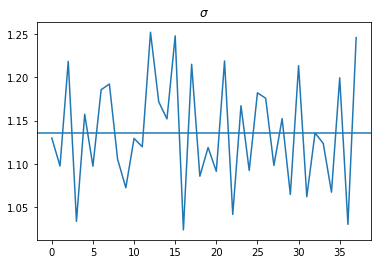

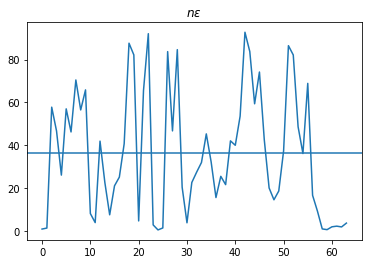

In [316]:
fit_sigma_mean_fixed_radius, fit_sigma_err_fixed_radius = get_average_fit_parameter(fitparams[:,0],r"$\sigma$")
fit_nepsilon_mean_fixed_radius, fit_nepsilon_err_fixed_radius = get_average_fit_parameter(fitparams[:,1],r"$n\epsilon$")

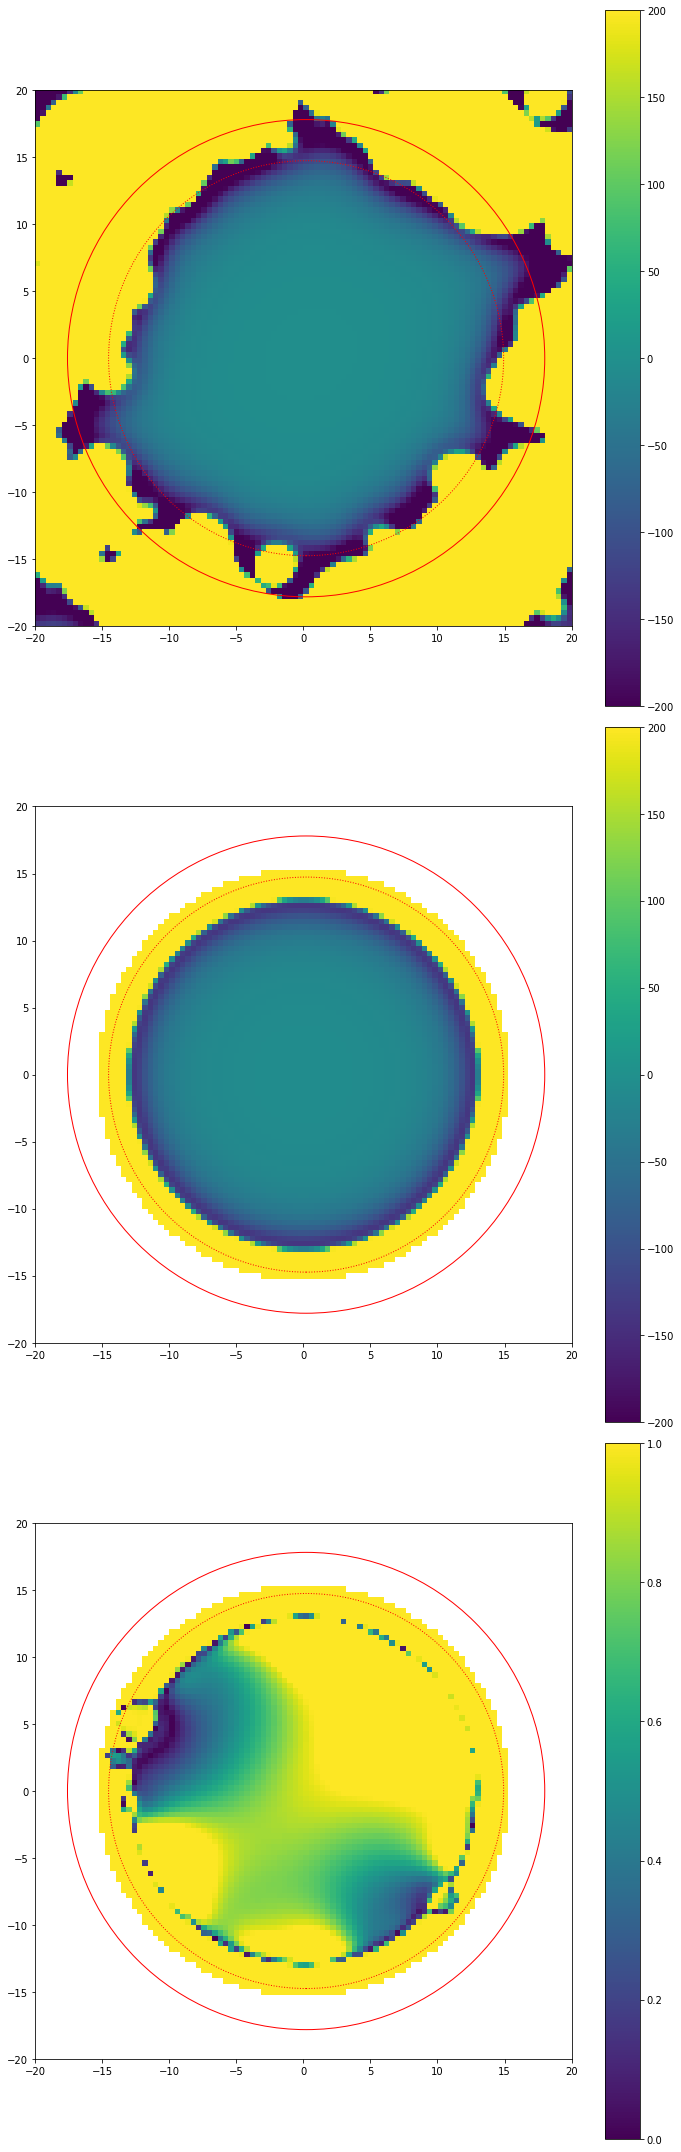

In [317]:
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh
y_predict = U_min2(xdata,fit_sigma_mean,fit_nepsilon_mean)
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),fit_radius_mean,facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),fit_radius_mean,facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),fit_radius_mean,facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

Results are worse than letting the radius be fit.

In [323]:
print(r'$\sigma={:.3f}\mathrm{{\unicode{{x212B}}}}$, $n\epsilon = {:.3f}\mathrm{{K\unicode{{x212B}}^{{-2}}}}$, and $R={:.3f}\mathrm{{\unicode{{x212B}}}}$'.format(fit_sigma_mean_fixed_radius,fit_nepsilon_mean_fixed_radius,pore_radius))

$\sigma=1.136\mathrm{\unicode{x212B}}$, $n\epsilon = 36.530\mathrm{K\unicode{x212B}^{-2}}$, and $R=15.510\mathrm{\unicode{x212B}}$


In [324]:
print("σ error: {}".format(fit_sigma_err_fixed_radius))
print("nε error: {}".format(fit_nepsilon_err_fixed_radius))

σ error: 0.010496567537372001
nε error: 3.6182790061675134


Let's check how varying some variables effects the final parameters.

In [326]:
angle

array([0.        , 0.08726646, 0.17453293, 0.26179939, 0.34906585,
       0.43633231, 0.52359878, 0.61086524, 0.6981317 , 0.78539816,
       0.87266463, 0.95993109, 1.04719755, 1.13446401, 1.22173048,
       1.30899694, 1.3962634 , 1.48352986, 1.57079633, 1.65806279,
       1.74532925, 1.83259571, 1.91986218, 2.00712864, 2.0943951 ,
       2.18166156, 2.26892803, 2.35619449, 2.44346095, 2.53072742,
       2.61799388, 2.70526034, 2.7925268 , 2.87979327, 2.96705973,
       3.05432619, 3.14159265, 3.22885912, 3.31612558, 3.40339204,
       3.4906585 , 3.57792497, 3.66519143, 3.75245789, 3.83972435,
       3.92699082, 4.01425728, 4.10152374, 4.1887902 , 4.27605667,
       4.36332313, 4.45058959, 4.53785606, 4.62512252, 4.71238898,
       4.79965544, 4.88692191, 4.97418837, 5.06145483, 5.14872129,
       5.23598776, 5.32325422, 5.41052068, 5.49778714, 5.58505361,
       5.67232007, 5.75958653, 5.84685299, 5.93411946, 6.02138592,
       6.10865238, 6.19591884, 6.28318531])

In [401]:
def scale_fitting_parameters(phimesh,rhomesh,Vmesh_pol,fit_func=U_min,initial_guess=[2.5, 5, 15.51],bin_size = 5,r_cut_fit = 15.51, max_V = 0.0,plot_results=False,silent=True):
    rhoarr=[]
    phiarr=[]
    varr=[]
    angle = np.arange(0,360 + bin_size,bin_size)*np.pi/180
    for i,a in enumerate(angle[0:-1]):
        phiind = (phimesh>=a)*(phimesh<angle[i+1])
        rhotmp = rhomesh[phiind]
        rhoind = np.argsort(rhotmp)
        rhoarr.append(rhomesh[phiind][rhoind])
        phiarr.append(phimesh[phiind][rhoind])
        varr.append(Vmesh_pol[phiind][rhoind])

    fitparams = []
    fiterr = []
    for i, c in enumerate(rhoarr):
        cind = c < r_cut_fit
        xdata = c[cind]
        ydata = varr[i][cind]

        fitind = (ydata < max_V)
        popt, pcov = curve_fit(fit_func, xdata[fitind], ydata[fitind],initial_guess,bounds=(np.zeros(len(initial_guess)),np.inf*np.ones(len(initial_guess))),maxfev=200000)

        perr = np.sqrt(np.diag(pcov))
        fitparams.append(popt)
        fiterr.append(perr)
    fitparams=np.array(fitparams)
    fiterr=np.array(fiterr)

    fit_sigma_mean, fit_sigma_err = get_average_fit_parameter(fitparams[:,0],r"$\sigma$",plot_results=plot_results,silent=silent)
    fit_nepsilon_mean, fit_nepsilon_err = get_average_fit_parameter(fitparams[:,1],r"$n\epsilon$",plot_results=plot_results,silent=silent)
    try:
        fit_radius_mean, fit_radius_err = get_average_fit_parameter(fitparams[:,2],r"$R$",plot_results=plot_results,silent=silent)
        return [fit_sigma_mean,fit_nepsilon_mean,fit_radius_mean, fit_sigma_err, fit_nepsilon_err, fit_radius_err]
    except:
        return [fit_sigma_mean, fit_nepsilon_mean, fit_sigma_err, fit_nepsilon_err]

In [360]:
from scipy.interpolate import griddata
interpolate_res = 1000j
grid_x, grid_y = np.mgrid[np.min(rmeshpoints[:,0]):np.max(rmeshpoints[:,0]):interpolate_res, np.min(rmeshpoints[:,1]):np.max(rmeshpoints[:,1]):1000j]
grid_z1 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='linear')

In [361]:
#Here we convert the x and y values in our test point mesh to Polar coordinates and sort based on angle
rhomesh_int,phimesh_int=cart2pol(grid_x.flatten(),grid_y.flatten())
rhomesh_int = rhomesh_int[np.argsort(phimesh_int)]
Vmesh_pol_int = grid_z1.flatten()[np.argsort(phimesh_int)]
phimesh_int=np.sort(phimesh_int)+np.pi

In [358]:
bin_min = 0.50
bin_max = 20.0
bin_res = 100
fitting_results = []
for bin_size in np.linspace(bin_min,bin_max,bin_res):
    print(bin_size)
    fitting_results.append(scale_fitting_parameters(phimesh_int,rhomesh_int,Vmesh_pol_int,bin_size=bin_size))

0.5
0.696969696969697
0.8939393939393939
1.0909090909090908
1.2878787878787878
1.4848484848484849
1.6818181818181817
1.8787878787878787
2.0757575757575757
2.2727272727272725
2.4696969696969697
2.6666666666666665


ValueError: `xdata` must not be empty!

In [362]:
scale_fitting_parameters2(phimesh_int,rhomesh_int,Vmesh_pol_int)

KeyboardInterrupt: 

Checking fits on interpolated data

In [374]:
#Here we convert the x and y values in our test point mesh to Polar coordinates and sort based on angle
rhomesh_int,phimesh_int=cart2pol(grid_x.flatten(),grid_y.flatten())
rhomesh_int = rhomesh_int[np.argsort(phimesh_int)]
Vmesh_pol_int = grid_z1.flatten()[np.argsort(phimesh_int)]
phimesh_int=np.sort(phimesh_int)+np.pi

In [368]:
from scipy.optimize import curve_fit
xdata = rhomesh_int
ydata = Vmesh_pol_int
r_cut_fit = pore_radius
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.00636657 0.00552099 0.00594853]
[ 4.15664757  0.9789328  18.67612613]


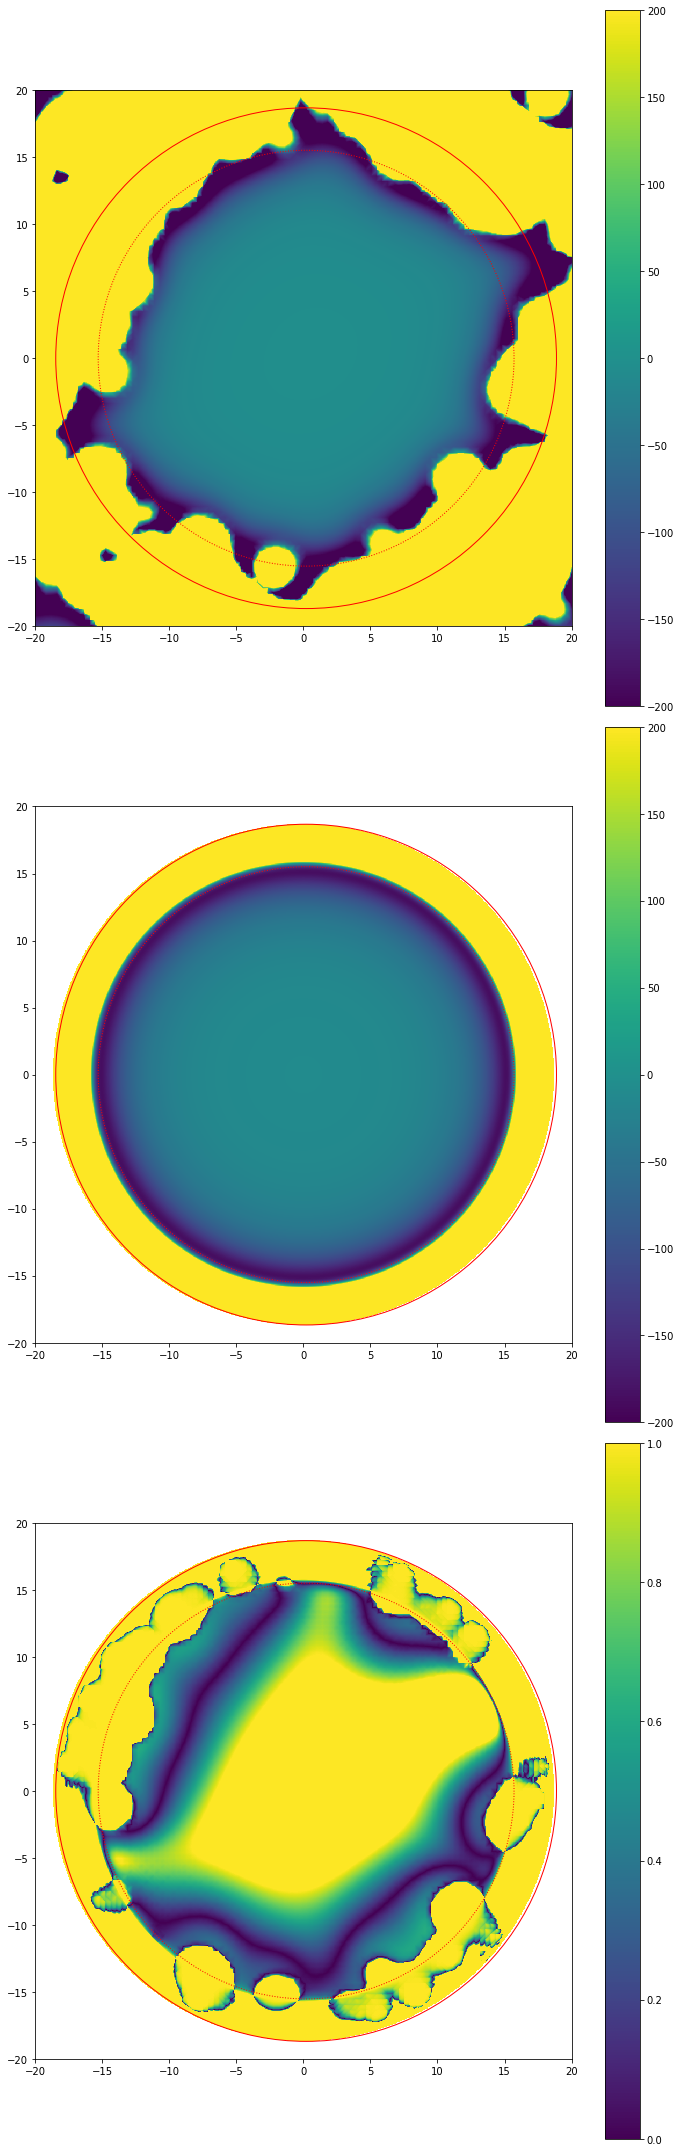

In [373]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = U_min(xdata,*popt)
res_mesh = 1000
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

We can see from the third plot that there are still regions with large amount of error. Can we do better by restricting the pore radius to the value reported by the author's of the MCM-41 cif?

In [202]:
def U_min_AB(r,A,B,R):
    return Veffective_AB(r,A,B,R)

In [378]:
#Here we convert the x and y values in our test point mesh to Polar coordinates and sort based on angle
rhomesh_int,phimesh_int=cart2pol(grid_x.flatten(),grid_y.flatten())
rhomesh_int = rhomesh_int[np.argsort(phimesh_int)]
Vmesh_pol_int = grid_z1.flatten()[np.argsort(phimesh_int)]
phimesh_int=np.sort(phimesh_int)+np.pi

In [383]:
from scipy.optimize import curve_fit
xdata = rhomesh_int
ydata = Vmesh_pol_int
r_cut_fit = pore_radius
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min_AB, xdata[fitind], ydata[fitind],[17569060,4500,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[3.49707503e+05 1.95551703e+01 5.94842464e-03]
[2.72693172e+07 5.28729237e+03 1.86760972e+01]


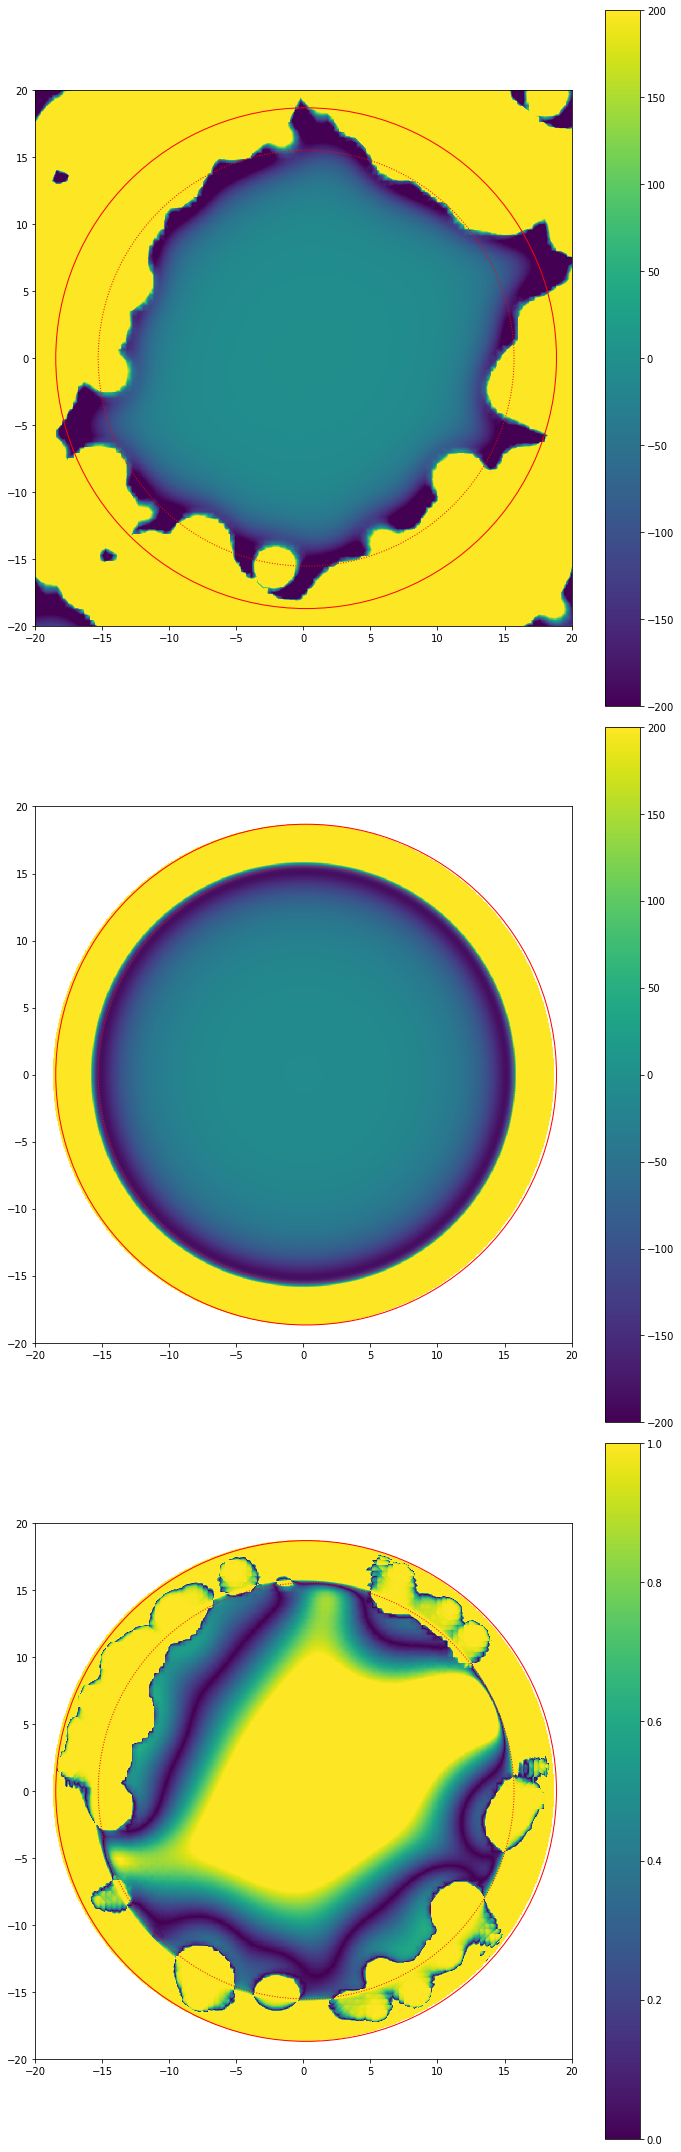

In [384]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = U_min_AB(xdata,*popt)
res_mesh = 1000
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

In [201]:
def U_min2_AB(r,A,B):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return Veffective_AB(r,A,B,pore_radius)

In [386]:
from scipy.optimize import curve_fit
xdata = rhomesh_int
ydata = Vmesh_pol_int
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
# We restrict fitting the data to within 10% of the pore wall so the large numbers generated near the wall don't cause numerical instabilites
percent_fit_radius_restricted = 0.95
r_cut_fit = mcm41_cif_pore_radius*percent_fit_radius_restricted

max_V = 0.0
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min2_AB, xdata[fitind], ydata[fitind],[17569060,4500],bounds=([0.0,0.0],[np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.70657243 0.2279581 ]
[242.89986554 143.11489612]


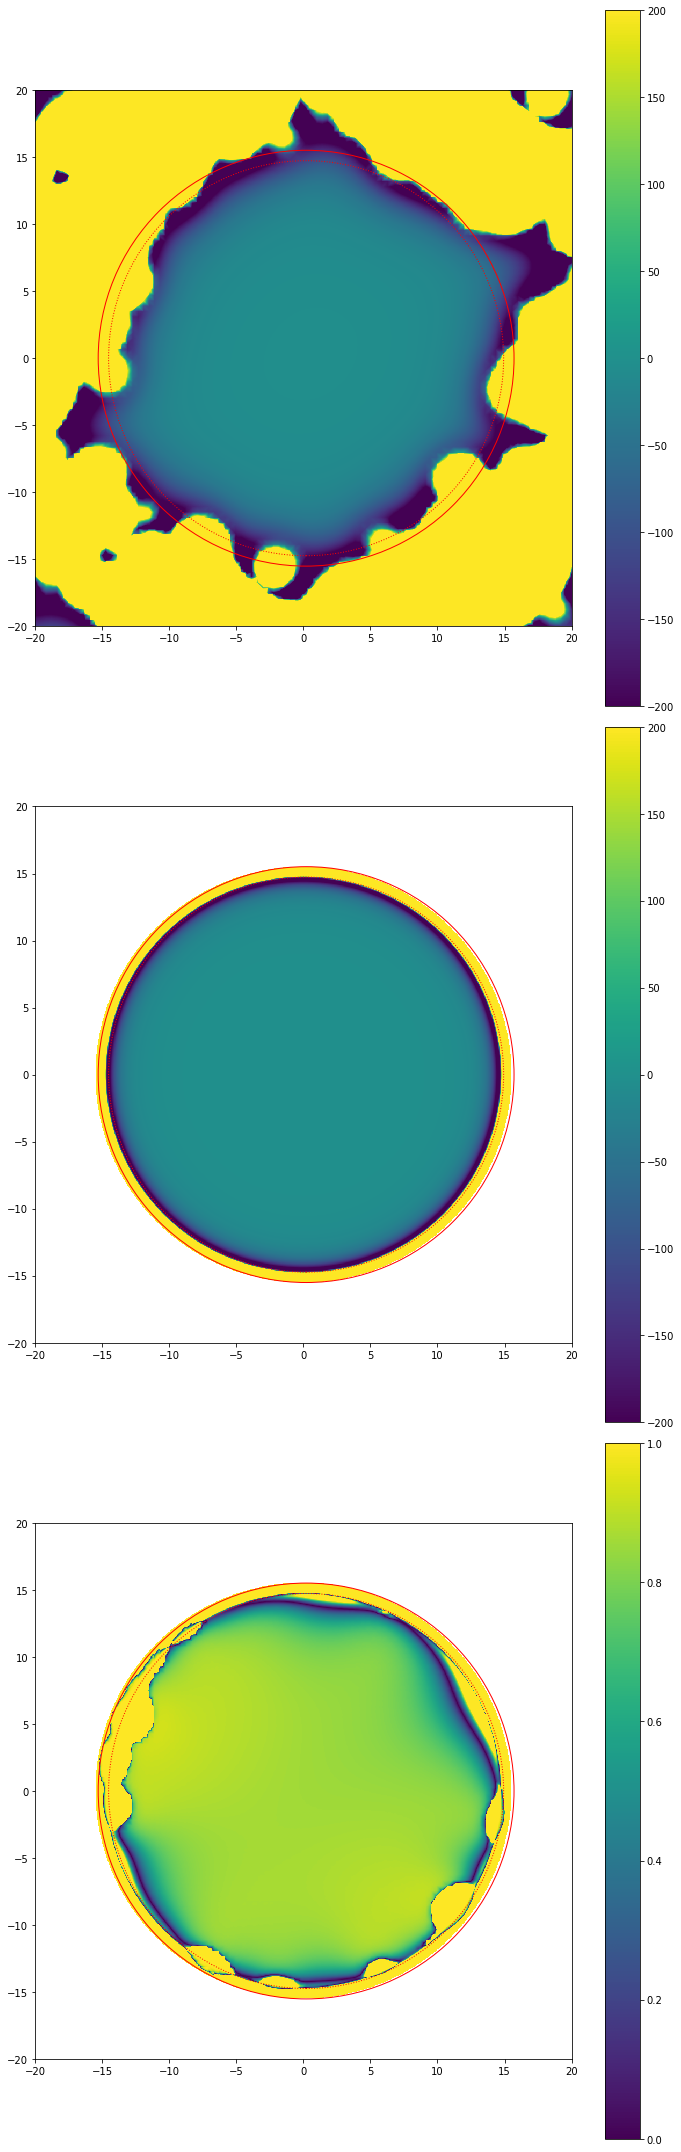

In [387]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = U_min2_AB(xdata,*popt)
res_mesh = 1000

extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)
                
fig.tight_layout()

In [200]:
def sigma_nepsilon_to_AB(sigma,n_epsilon):
    A = (sigma**9)*np.pi*n_epsilon*(sigma**3)/3.0
    B = (sigma**3)*np.pi*n_epsilon*(sigma**3)/3.0
    return A,B

def sigma_nepsilon_to_AB_err(sigma,n_epsilon,sigma_err,n_epsilon_err):
    A = (sigma**12)*np.pi*n_epsilon/3
    B = (sigma**6)*np.pi*n_epsilon/3
    A_err = np.sqrt((((4*np.pi*(sigma**11)*n_epsilon) * sigma_err)**2) + ((((sigma**12)*np.pi/3) * n_epsilon_err)**2))
    B_err = np.sqrt((((2*np.pi*(sigma**5)*n_epsilon) * sigma_err)**2) + ((((sigma**6)*np.pi/3) * n_epsilon_err)**2))
    return A,B,A_err,B_err

def AB_to_sigma_nepsilon(A,B):
    sigma = ((A/B)**(1/6))
    n_epsilon = 3.0*(B**2)/A/(np.pi)
    return sigma,n_epsilon

def AB_to_sigma_nepsilon_err(A,B,A_err,B_err):
    sigma = ((A/B)**(1/6))
    sigma_err = np.sqrt((((((A/B)**(1/6))/(6*A)) * A_err)**2) + (((((A/B)**(1/6))/(-6*B)) * B_err)**2))
    n_epsilon = 3*(B**2)/A/np.pi
    n_epsilon_err = np.sqrt((((-3*(B**2)/(A**2)/(np.pi)) * A_err)**2) + (((6*B/A/np.pi) * B_err)**2))
    return sigma,n_epsilon,sigma_err,n_epsilon_err

In [399]:
fit_params = AB_to_sigma_nepsilon_err(*popt,*perr)

In [402]:
#Here we convert the x and y values in our test point mesh to Polar coordinates and sort based on angle
rhomesh_int,phimesh_int=cart2pol(grid_x.flatten(),grid_y.flatten())
rhomesh_int = rhomesh_int[np.argsort(phimesh_int)]
Vmesh_pol_int = grid_z1.flatten()[np.argsort(phimesh_int)]
phimesh_int=np.sort(phimesh_int)+np.pi

In [404]:
fit_func = U_min
test1 = scale_fitting_parameters(phimesh_int,rhomesh_int,Vmesh_pol_int,fit_func=fit_func)

In [408]:
print(test1)

[3.4573072242046288, 1.0788809334309635, 17.99389451993941, 0.04493657513203639, 0.06714432288654726, 0.09680314198194963]


In [ ]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = fit_func(xdata,*popt)
res_mesh = 1000
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

In [407]:
sigma_nepsilon_to_AB(*test1[:2])

(3295018.216372781, 1929.4342252454373)

In [409]:
fit_func = U_min_AB
test2 = scale_fitting_parameters(phimesh_int,rhomesh_int,Vmesh_pol_int,fit_func=fit_func,initial_guess=[3300000.0,2000.0,18.0])

In [410]:
print(test2)

[3985381.841904678, 2574.4790242305257, 17.968656177197882, 299209.8322122451, 92.15871761007371, 0.08825560678855512]


In [412]:
AB_to_sigma_nepsilon_err(*test2[:2],*test2[-3:-1])

(3.4011837594779135,
 1.5881084616574583,
 0.047148492216442454,
 0.16475231418122682)

In [415]:
popt = test2[:3]

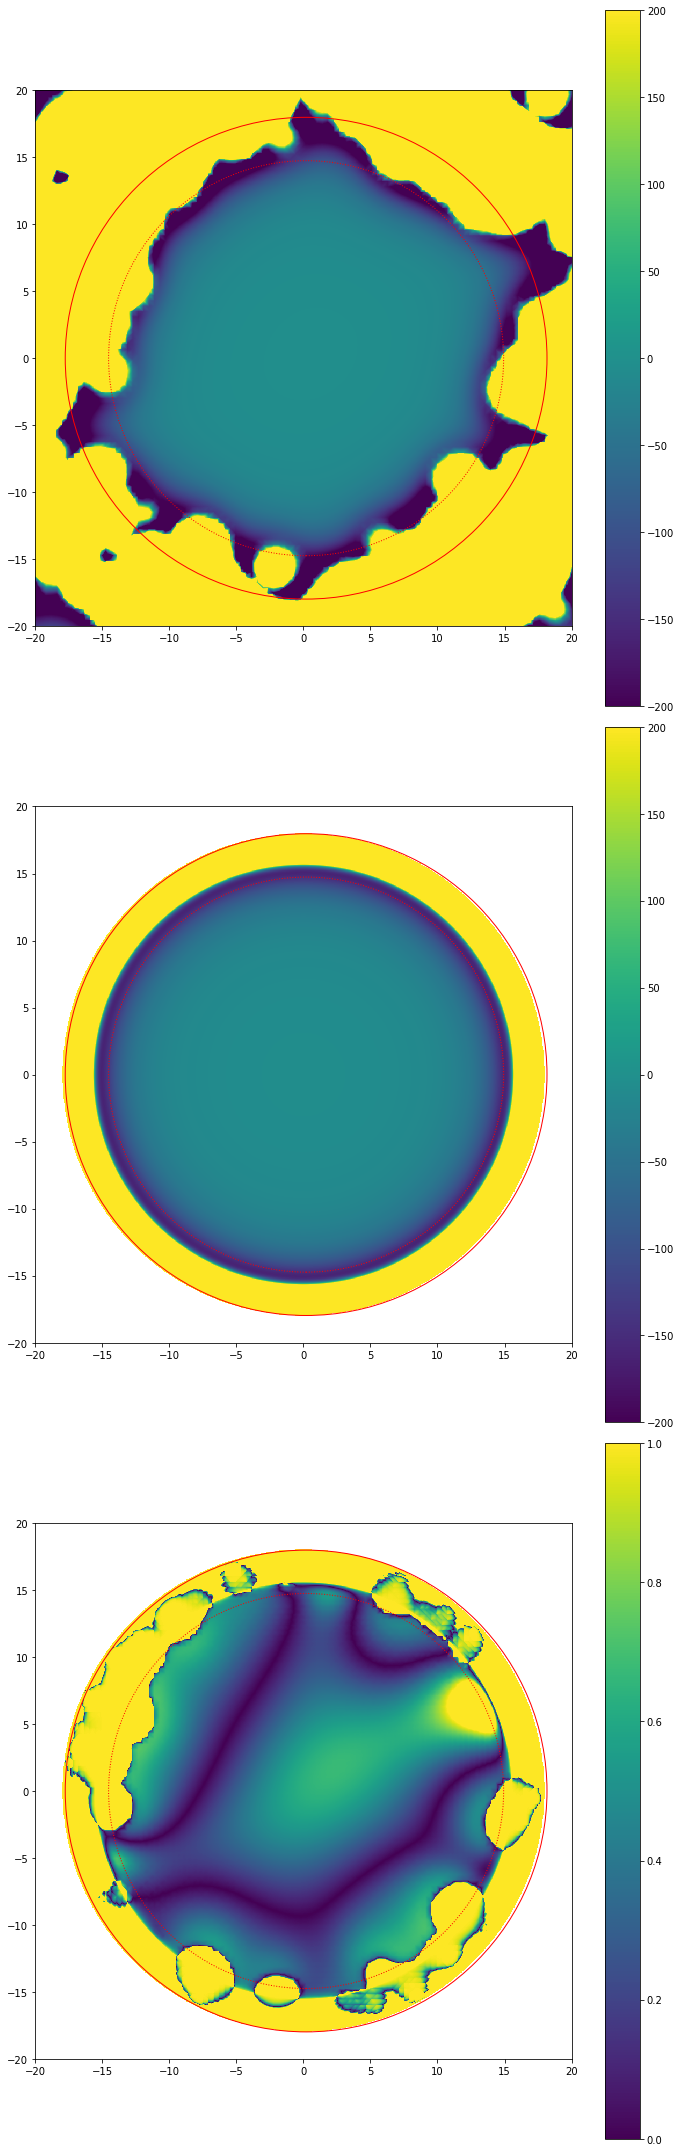

In [416]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = fit_func(xdata,*popt)
res_mesh = 1000
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),popt[2],facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

In [418]:
fit_func = U_min2
test3 = scale_fitting_parameters(phimesh_int,rhomesh_int,Vmesh_pol_int,fit_func=fit_func,initial_guess=[2.5,5.0])

In [419]:
print(test3)

[6.98854379340474e-05, 0.00012855501510208994, 1.363268112015458e-05, 2.5983255536861e-05]


In [420]:
popt = test3[:2]

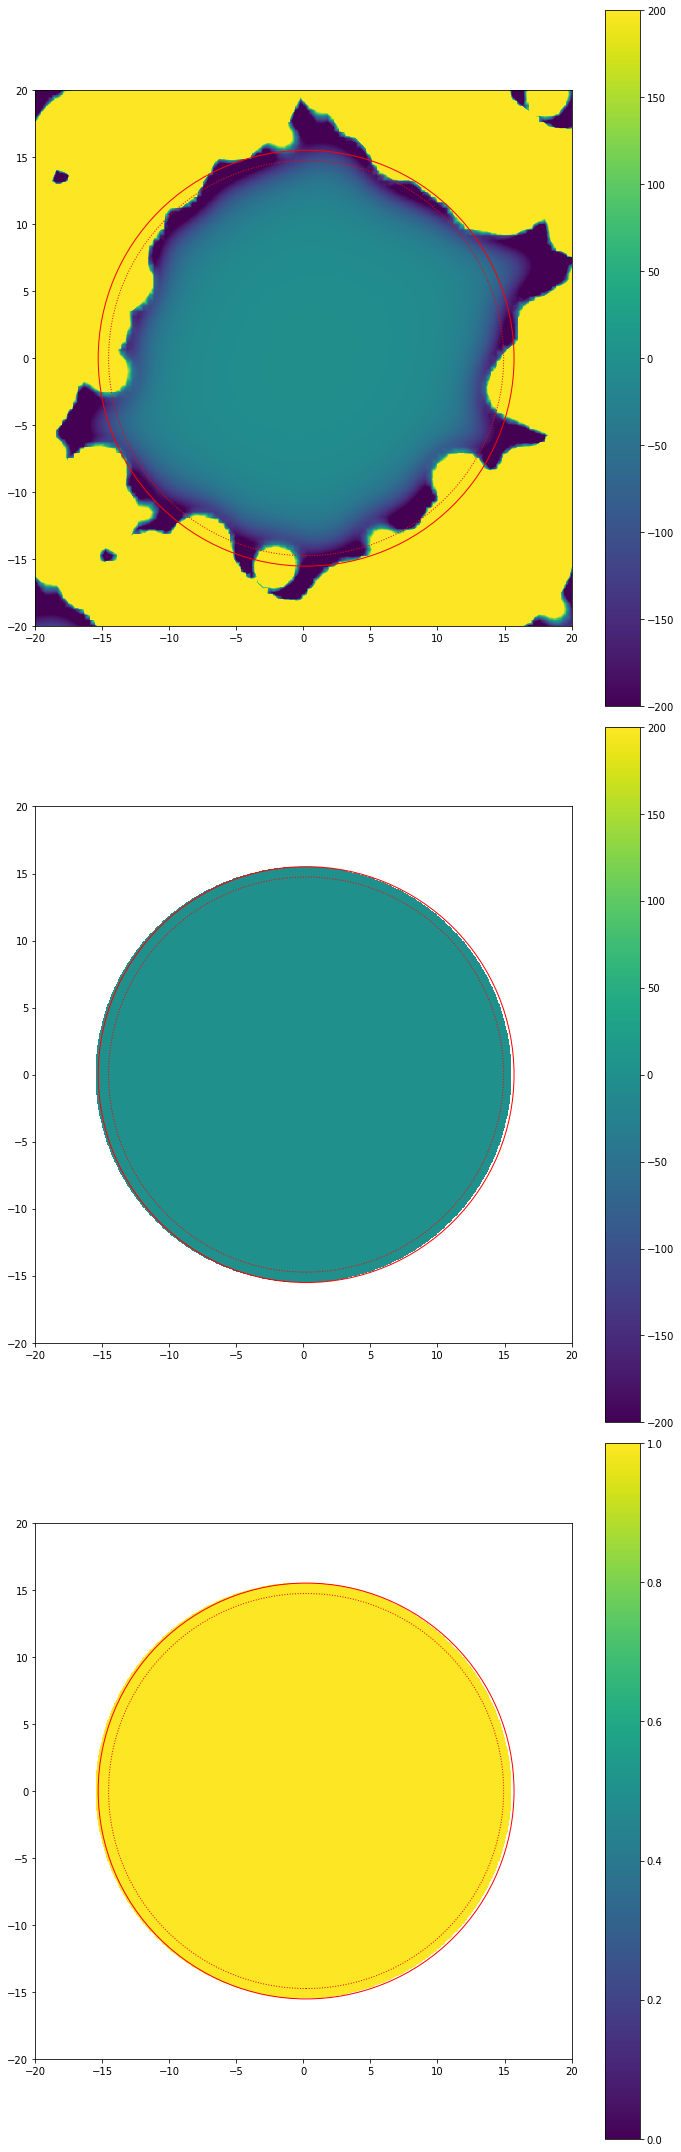

In [422]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = fit_func(xdata,*popt)
res_mesh = 1000
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()

In [423]:
sigma_nepsilon_to_AB(*test3[:2])

(1.8270815566985164e-54, 1.5683312194869872e-29)

In [424]:
fit_func = U_min2_AB
test4 = scale_fitting_parameters(phimesh_int,rhomesh_int,Vmesh_pol_int,fit_func=fit_func,initial_guess=[3300000.0,2000.0])

In [425]:
print(test4)

[5.134131268523991e-21, 41946740822.1621, 3.79475124388949e-21, 9110565614.42657]


In [426]:
AB_to_sigma_nepsilon_err(*test4)

(7.046305322841446e-06,
 3.2726597781541275e+41,
 9.047141932023823e-07,
 2.805710207993336e+41)

In [427]:
popt = test4[:2]

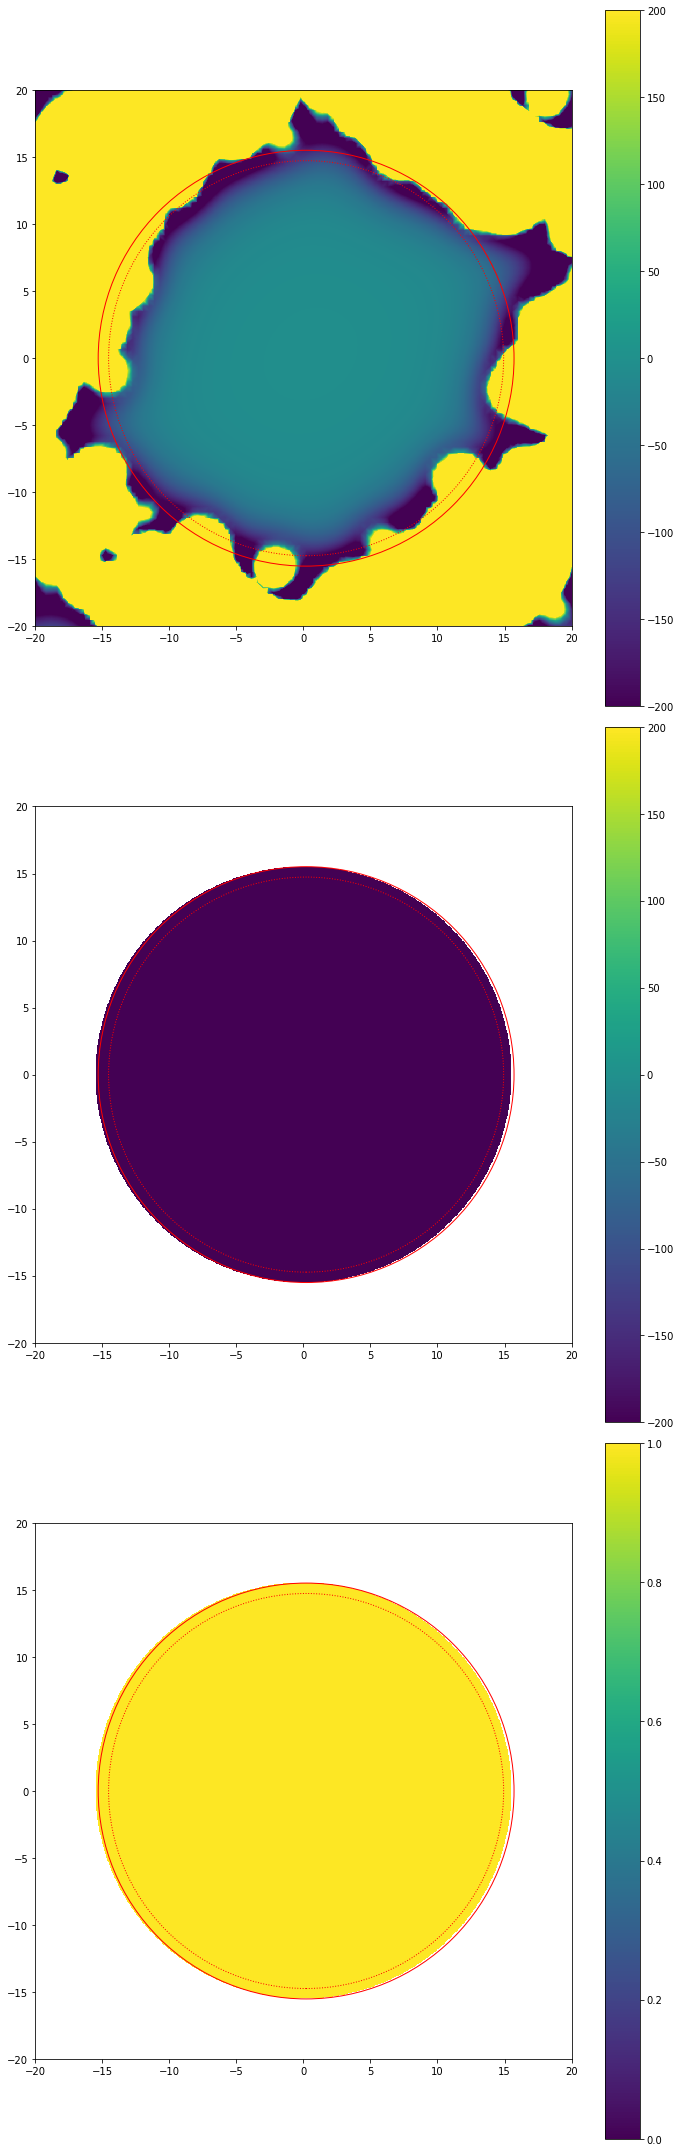

In [428]:
xdata = cart2pol(grid_x,grid_y)[0]
ydata = grid_z1
y_predict = fit_func(xdata,*popt)
res_mesh = 1000
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots(3,figsize=(10,30))
im = ax[0].imshow(ydata.reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar = fig.colorbar(im,ax=ax[0])
im2  = ax[1].imshow((y_predict).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=200,vmin=-200)
cbar2 = fig.colorbar(im2,ax=ax[1])
im3 = ax[2].imshow(np.abs((ydata - y_predict)/ydata).reshape(res_mesh,res_mesh).T,origin='lower',extent=extent,vmax=1,vmin=0)
cbar3 = fig.colorbar(im3,ax=ax[2])

circ = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ2 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circ3 = Circle((.2,0),mcm41_cif_pore_radius,facecolor='None',edgecolor='r')
circr = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr2 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
circr3 = Circle((.2,0),r_cut_fit,facecolor='None',edgecolor='r',linestyle=':')
ax[0].add_patch(circ)
ax[1].add_patch(circ2)
ax[2].add_patch(circ3)
ax[0].add_patch(circr)
ax[1].add_patch(circr2)
ax[2].add_patch(circr3)

fig.tight_layout()